# Light Curve Parameter Inference Using LFI -- Tutorial

# Imports

## Python Packages

In [ ]:
# general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import os, sys, time, glob
import json
import copy
import scipy
import warnings
from tqdm import tqdm

In [4]:
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [5]:
# bilby
import bilby
from bilby.core.prior import Uniform, DeltaFunction
from bilby.core.likelihood import GaussianLikelihood

In [6]:
# nflows
from nflows.nn.nets.resnet import ResidualNet
from nflows import transforms, distributions, flows
from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation
import nflows.utils as torchutils

In [7]:
# extras
from IPython.display import clear_output
from time import time
from time import sleep
import corner
import torchvision
import torchvision.transforms as transforms
from os.path import exists

## Personal Functions

In [8]:
# importing dataloading functions

# these functions are used to open the data and assign data id's
from model.data_processing import open_json, get_names, json_to_df, add_batch_sim_nums_all, get_test_names

# these functions are used to ensure the data are the same length (121 points)
from model.data_processing import pad_the_data, pad_all_dfs

# these functions are used to read in data when it is in csv format
from model.data_processing import load_in_data, match_fix_to_var, matched

# these functions are used to convert csv files to tensors and create a dataset
from model.data_processing import repeated_df_to_tensor, Paper_data

In [9]:
# importing similarity embedding functions

from model.embedding import VICRegLoss, ConvResidualBlock, ConvResidualNet, SimilarityEmbedding, train_one_epoch_se, val_one_epoch_se

# importing resnet from ML4GW pe

from model.resnet import ResNet

In [10]:
# importing normalizing flow functions

from model.normalizingflows import Flow_data, EmbeddingNet, normflow_params, train_one_epoch, val_one_epoch

In [11]:
# importing inference functions

from model.inference import cast_as_bilby_result, live_plot_samples, ppplot, comparison_plot

## Setting Device

In [12]:
# checking gpu status, ensures tensors are stored on the same device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


# Data Specific Parameters and Priors

Light curve generation is done through the nmma package on github: https://github.com/nuclear-multimessenger-astronomy/nmma/tree/main. To properly encode the effects of changing $t$ and $d_L$, each combination of our physical parameters $\log_{10}(M_{ej})$, $\log_{10}(V_{ej})$, and $\log_{10}(X_{lan})$ are repeated 50 times to produce light curves with unique noise instances. A second set of 50 light curves is created by adjusting $t$ and $d_L$ according to the priors shown below. Our training dataset contains 8,729 unique combinations of $\log_{10}(M_{ej})$, $\log_{10}(V_{ej})$, and $\log_{10}(X_{lan})$, resulting in $8,729 \times 50 \times 2 = 872,900$ total light curves.

In [13]:
# json specific parameters, adjust this cell with commands when generating light curves -- MANDATORY

bands = ['ztfg', 'ztfr', 'ztfi']
detection_limit = 22.0
num_repeats = 50
num_channels = 3
num_points = 33
in_features = num_points
data_dir = '/nobackup/users/mmdesai/new_csv/'

In [14]:
# time shift

t_zero = 44242.00021937881
t_min = 44240.0012975024
t_max = 44269.99958898723
days = int(round(t_max - t_min))
time_step = 1

In [15]:
# priors

priors = dict()
priors['log10_mej'] = Uniform(-1.9, -1, name='log10_mej', latex_label='$\log(M_{{ej}})$')
priors['log10_vej'] = Uniform(-1.52, -0.53, name='log10_vej', latex_label='$\log(V_{{ej}})$')
priors['log10_Xlan'] = Uniform(-9, -3, name='log10_Xlan', latex_label='$\log(X_{{lan}})$')
priors['timeshift'] = Uniform(-2, 6, name='timeshift', latex_label='$\Delta\;t$')
priors['distance'] = Uniform(50, 200, name='luminosity distance', latex_label='$D$')

# Data Processing

This section processes data generated through NMMA. Use this section as a guide for converting the .json files into dataframes. The dataframes are subsequently stored as .csv files. If using the data from Zenodo, skip ahead to the Tensor Processing section. 

### Varied Data

In [16]:
dir_path       = '/home/oppenheimer/summer2025/Kilo/data/lc_dir/varied/'
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']

In [15]:
# your existing helper to open a single .json
def open_json(file_name, dir_path):
    with open(os.path.join(dir_path, file_name)) as f:
        return json.load(f)

# your existing json → DataFrame function
def json_to_df(file_name, dir_path, detection_limit, bands):
    data = open_json(file_name, dir_path)
    df = pd.DataFrame.from_dict(data, orient="columns")
    df_unpacked = pd.DataFrame(columns=['t'] + bands)
    counter = 0
    for j, band in enumerate(bands):
        # unpack each band’s [t, value, x]
        df_unpacked[['t', band, 'x']] = pd.DataFrame(
            df[band].tolist(), index=df.index
        )
        counter += (df_unpacked[band] != detection_limit).sum()
    df_unpacked['num_detections'] = counter
    return df_unpacked.drop(columns=['x'])

# parameters
dir_path       = '/home/oppenheimer/summer2025/Kilo/data/varied/'
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
# find all your test_*.json files
file_pattern = os.path.join(dir_path, 'test_varied_*.json')
all_files    = sorted(glob.glob(file_pattern))  # gives absolute paths

# process them all into a list of DataFrames
df_list = [
    json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    for fp in all_files
]

print(len(df_list), "files found.")
# if you want one big DataFrame
df_all = pd.concat(df_list, ignore_index=True)

# now df_all contains the flattened photometry from all 25 000 files
print(df_all.shape)  


KeyboardInterrupt: 

In [18]:
print(df_list[3])

#minimum tim across all df_list entries
min_time = min([df['t'].min() for df in df_list])
#maximum time across all df_list entries
max_time = max([df['t'].max() for df in df_list])

print(f"Minimum time: {min_time}, Maximum time: {max_time}")

               t       ztfg       ztfr       ztfi  num_detections
0   44240.800104  22.000000  22.000000  22.000000               7
1   44241.800104  22.000000  22.000000  22.000000               7
2   44242.800104  22.000000  22.000000  22.000000               7
3   44243.800104  21.135319  20.302227  19.845085               7
4   44244.800104  22.000000  21.369307  20.572730               7
5   44245.800104  22.000000  22.000000  21.370017               7
6   44246.800104  22.000000  22.000000  21.974132               7
7   44247.800104  22.000000  22.000000  22.000000               7
8   44248.800104  22.000000  22.000000  22.000000               7
9   44249.800104  22.000000  22.000000  22.000000               7
10  44250.800104  22.000000  22.000000  22.000000               7
11  44251.800104  22.000000  22.000000  22.000000               7
12  44252.800104  22.000000  22.000000  22.000000               7
13  44253.800104  22.000000  22.000000  22.000000               7
14  44254.

In [17]:
dir_path       = '/home/oppenheimer/summer2025/Kilo/data/varied/'
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']

In [17]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
# dir_path        = "/path/to/your/jsons"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 5000        # how many sims to process per batch
batch_size      = 50          # sims per batch for batch_id
output_csv      = "all_lightcurves_varied.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
t_min = np.floor(raw_min)
t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_all = pd.read_csv(output_csv)
print("Final table shape:", df_all.shape)
print("Time spans:", df_all['t'].min(), "→", df_all['t'].max())
print("Unique batch_ids:", sorted(df_all['batch_id'].unique()))


100%|██████████| 5000/5000 [00:06<00:00, 766.77it/s]


Final table shape: (3300000, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,

In [18]:
output_csv      = "/home/oppenheimer/summer2025/Kilo/csv files/all_lightcurves_varied.csv"

df_all = pd.read_csv(output_csv)
print("Final table shape:", df_all.shape)
print("Time spans:", df_all['t'].min(), "→", df_all['t'].max())
print("Unique batch_ids:", sorted(df_all['batch_id'].unique()))



Final table shape: (3300000, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,

In [19]:
# print(df_list[3])
# print(padded_list[3])

#print df_all with a particular sim_id
sim_id = 10  # change this to the sim_id you want to inspect
df_sim = df_all[df_all['sim_id'] == sim_id]
print(f"Data for sim_id {sim_id}:\n", df_sim)

Data for sim_id 10:
                 t       ztfg       ztfr       ztfi  sim_id  num_detections  \
330  44240.000000  22.000000  22.000000  22.000000      10              37   
331  44241.000000  22.000000  22.000000  22.000000      10              37   
332  44242.000000  22.000000  22.000000  22.000000      10              37   
333  44243.000000  22.000000  22.000000  22.000000      10              37   
334  44244.000000  22.000000  22.000000  22.000000      10              37   
335  44245.000000  22.000000  22.000000  22.000000      10              37   
336  44245.075112  22.000000  22.000000  22.000000      10              37   
337  44246.075112  22.000000  22.000000  22.000000      10              37   
338  44247.075112  22.000000  22.000000  22.000000      10              37   
339  44248.075112  19.110038  19.661566  20.268933      10              37   
340  44249.075112  19.140999  19.090341  19.665282      10              37   
341  44250.075112  20.013648  19.020863  19

In [ ]:
varied_simembed_dict = {}

In [ ]:
# get the varied data

sim_path = '/nobackup/users/mmdesai/lowcsimdata'
num_sims = 25000

simembed_num_lc_list = [24750, 25000, 25000, 25000, 25000, 25000, 24850, 25000, 25000, 25000]

for i in range (0, 10):
    # get the names of each file
    file_names = get_names(sim_path, 'varied', i, simembed_num_lc_list[i])
    # open the files as dataframes
    varied_simembed_dict['varied_simembed_data_{}'.format(i)] = json_to_df(file_names, simembed_num_lc_list[i])
    # pad the data
    varied_simembed_dict['varied_simembed_data_{}'.format(i)] = pad_all_dfs(varied_simembed_dict['varied_simembed_data_{}'.format(i)])

In [ ]:
varied_simembed_dict['varied_simembed_data_0'][-1]

In [ ]:
# plot a small sample of the varied light curves

for i in range(0, 300, 50):
    plt.scatter(varied_simembed_dict['varied_simembed_data_0'][i]['t'], varied_simembed_dict['varied_simembed_data_0'][i]['ztfg'], color = 'g')
    plt.scatter(varied_simembed_dict['varied_simembed_data_0'][i]['t'], varied_simembed_dict['varied_simembed_data_0'][i]['ztfr'], color = 'r')
    plt.scatter(varied_simembed_dict['varied_simembed_data_0'][i]['t'], varied_simembed_dict['varied_simembed_data_0'][i]['ztfi'], color = 'c')
plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')

In [20]:
inj_path_simembed = '/home/oppenheimer/summer2025/Kilo/data/varied/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

            mej       vej      xlan     shift    distance  sim_id
0     -1.120642 -1.349671 -6.515489 -0.366574   55.820182       0
1     -1.120642 -1.349671 -6.515489  2.008821   55.820182       1
2     -1.120642 -1.349671 -6.515489  1.731389   55.820182       2
3     -1.120642 -1.349671 -6.515489  4.249425   55.820182       3
4     -1.120642 -1.349671 -6.515489 -1.490093   55.820182       4
...         ...       ...       ...       ...         ...     ...
99995 -1.387312 -0.549166 -7.111814  2.394250  163.524313   99995
99996 -1.387312 -0.549166 -7.111814 -0.715243  163.524313   99996
99997 -1.387312 -0.549166 -7.111814 -1.198648  163.524313   99997
99998 -1.387312 -0.549166 -7.111814  1.264847  163.524313   99998
99999 -1.387312 -0.549166 -7.111814  4.353680  163.524313   99999

[100000 rows x 6 columns]


In [21]:
# if your varied_injections DataFrame calls its sim key something else, rename it:
# varied_injections = varied_injections.rename(columns={ 'simulation_id': 'sim_id' })

# select only the columns you care about from injections
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final = df_all.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final.shape)  # should be (~3 300 000, original_cols+5)


Final shape: (3300000, 12)


In [22]:
# print a particular sim_id
sim_id = 10  # change this to the sim_id you want to inspect
df_sim = df_final[df_final['sim_id'] == sim_id]
print(f"Data for sim_id {sim_id}:\n", df_sim)

Data for sim_id 10:
                 t       ztfg       ztfr       ztfi  sim_id  num_detections  \
330  44240.000000  22.000000  22.000000  22.000000      10              37   
331  44241.000000  22.000000  22.000000  22.000000      10              37   
332  44242.000000  22.000000  22.000000  22.000000      10              37   
333  44243.000000  22.000000  22.000000  22.000000      10              37   
334  44244.000000  22.000000  22.000000  22.000000      10              37   
335  44245.000000  22.000000  22.000000  22.000000      10              37   
336  44245.075112  22.000000  22.000000  22.000000      10              37   
337  44246.075112  22.000000  22.000000  22.000000      10              37   
338  44247.075112  22.000000  22.000000  22.000000      10              37   
339  44248.075112  19.110038  19.661566  20.268933      10              37   
340  44249.075112  19.140999  19.090341  19.665282      10              37   
341  44250.075112  20.013648  19.020863  19

In [ ]:
merged_list = []
for i, df in enumerate(padded_list):
    inj = varied_injections.iloc[i]  # a Series with index ['mej','vej',…,'sim_id']
    # drop the sim_id from inj if you don’t want to re–assign it
    for col in ['mej','vej','xlan','shift','distance']:
        df[col] = inj[col]
    merged_list.append(df)

# finally, glue them all together
df_final = pd.concat(merged_list, ignore_index=True)
print(df_final)

In [ ]:
# print df_final with a particular sim_id
print(df_final[df_final['sim_id'] == 24999])

In [ ]:
# injection files for the additional data

inj_path_simembed = '/nobackup/users/mmdesai/final_injections'
varied_injections = {}

for i in range(0, 10):
    varied_inj_df = pd.DataFrame()
    varied_params = open_json('/injection_simembed_varied_{}.json'.format(i), inj_path_simembed)
    varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
    varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
    varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
    varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
    varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
    varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
    varied_injections['varied_inj_df{}'.format(i)] = varied_inj_df

In [ ]:
varied_injections['varied_inj_df0']

In [ ]:
# concatenate dataframe lists

all_varied_data_list = [0] * 10

for i in range(0, 10):
    all_varied_data_list[i] = pd.concat(varied_simembed_dict['varied_simembed_data_{}'.format(i)])

In [ ]:
# merge with injection parameters

all_varied_datawparams_list = [0] * 10

for i in range(0, 10):
    all_varied_datawparams_list[i] = all_varied_data_list[i].merge(varied_injections['varied_inj_df{}'.format(i)], on = 'sim_id')
    # save as csv file
    all_varied_datawparams_list[i].to_csv('/nobackup/users/mmdesai/final_csv/varied_lowc_{}.csv'.format(i), index = False)

In [ ]:
all_varied_datawparams_list[0]

### Fixed Data

In [23]:
dir_path= '/home/oppenheimer/summer2025/Kilo/data/fixed/'
detection_limit = 22.0
bands= ['ztfg', 'ztfr', 'ztfi']

In [23]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
# dir_path        = "/path/to/your/jsons"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 5000        # how many sims to process per batch
batch_size      = 50          # sims per batch for batch_id
output_csv      = "all_lightcurves_fixed.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
# t_min = np.floor(raw_min)
# t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_fixed_all = pd.read_csv(output_csv)
print("Final table shape:", df_fixed_all.shape)
print("Time spans:", df_fixed_all['t'].min(), "→", df_fixed_all['t'].max())
print("Unique batch_ids:", sorted(df_fixed_all['batch_id'].unique()))


100%|██████████| 5000/5000 [00:13<00:00, 380.45it/s]


Final table shape: (3300000, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,

In [26]:
output_csv = "/home/oppenheimer/summer2025/Kilo/csv files/all_lightcurves_fixed.csv"

df_fixed_all = pd.read_csv(output_csv)
print("Final table shape:", df_fixed_all.shape)
print("Time spans:", df_fixed_all['t'].min(), "→", df_fixed_all['t'].max())
print("Unique batch_ids:", sorted(df_fixed_all['batch_id'].unique()))


Final table shape: (3300000, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,

In [27]:
# print(padded_fixed_list[5])
# print(df_fixed_list[5])

# print df_fixed_all with a particular sim_id
sim_id = 10  # change this to the sim_id you want to inspect
df_sim = df_fixed_all[df_fixed_all['sim_id'] == sim_id]
print(f"Data for sim_id {sim_id}:\n", df_sim)

Data for sim_id 10:
                t       ztfg       ztfr       ztfi  sim_id  num_detections  \
330  44240.00000  22.000000  22.000000  22.000000      10              60   
331  44241.00000  22.000000  22.000000  22.000000      10              60   
332  44242.00000  22.000000  22.000000  22.000000      10              60   
333  44242.00022  22.000000  22.000000  22.000000      10              60   
334  44243.00022  22.000000  22.000000  22.000000      10              60   
335  44244.00022  22.000000  22.000000  22.000000      10              60   
336  44245.00022  17.145345  17.623111  18.076935      10              60   
337  44246.00022  17.143432  17.069614  17.671326      10              60   
338  44247.00022  17.928887  17.030182  17.385903      10              60   
339  44248.00022  18.524113  17.230774  17.263914      10              60   
340  44249.00022  19.262379  17.584594  17.372873      10              60   
341  44250.00022  19.919288  17.869367  17.645817      

In [28]:
inj_path_simembed = '/home/oppenheimer/summer2025/Kilo/data/fixed/'

fixed_inj_df = pd.DataFrame()
fixed_params = open_json('injection_fixed.json', inj_path_simembed)
fixed_inj_df['mej'] = fixed_params['injections']['content']['log10_mej']
fixed_inj_df['vej'] = fixed_params['injections']['content']['log10_vej']
fixed_inj_df['xlan'] = fixed_params['injections']['content']['log10_Xlan']
fixed_inj_df['shift'] = fixed_params['injections']['content']['timeshift']
fixed_inj_df['distance'] = fixed_params['injections']['content']['luminosity_distance']
fixed_inj_df['sim_id'] = fixed_params['injections']['content']['simulation_id']
fixed_injections = fixed_inj_df

print(fixed_injections)

            mej       vej      xlan  shift  distance  sim_id
0     -1.120642 -1.349671 -6.515489      0        50       0
1     -1.120642 -1.349671 -6.515489      0        50       1
2     -1.120642 -1.349671 -6.515489      0        50       2
3     -1.120642 -1.349671 -6.515489      0        50       3
4     -1.120642 -1.349671 -6.515489      0        50       4
...         ...       ...       ...    ...       ...     ...
99995 -1.387312 -0.549166 -7.111814      0        50   99995
99996 -1.387312 -0.549166 -7.111814      0        50   99996
99997 -1.387312 -0.549166 -7.111814      0        50   99997
99998 -1.387312 -0.549166 -7.111814      0        50   99998
99999 -1.387312 -0.549166 -7.111814      0        50   99999

[100000 rows x 6 columns]


In [29]:
# if your varied_injections DataFrame calls its sim key something else, rename it:
# varied_injections = varied_injections.rename(columns={ 'simulation_id': 'sim_id' })

# select only the columns you care about from injections
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_fixed_final = df_fixed_all.merge(
    fixed_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_fixed_final.shape)  # should be (~3 300 000, original_cols+5)


Final shape: (3300000, 12)


In [ ]:
merged_fixed_list = []
for i, df in enumerate(padded_fixed_list):
    inj = fixed_injections.iloc[i]  # a Series with index ['mej','vej',…,'sim_id']
    # drop the sim_id from inj if you don’t want to re–assign it
    for col in ['mej','vej','xlan','shift','distance']:
        df[col] = inj[col]
    merged_fixed_list.append(df)

# finally, glue them all together
df_fixed_final = pd.concat(merged_fixed_list, ignore_index=True)
print(df_fixed_final)

In [28]:
#print df_fixed_final with a particular sim_id
print(df_fixed_final[df_fixed_final['sim_id'] == 0])

              t       ztfg       ztfr       ztfi  sim_id  num_detections  \
0   44240.00000  22.000000  22.000000  22.000000       0              58   
1   44241.00000  22.000000  22.000000  22.000000       0              58   
2   44242.00000  22.000000  22.000000  22.000000       0              58   
3   44242.00022  22.000000  22.000000  22.000000       0              58   
4   44243.00022  22.000000  22.000000  22.000000       0              58   
5   44244.00022  22.000000  22.000000  22.000000       0              58   
6   44245.00022  17.645770  18.177220  18.511962       0              58   
7   44246.00022  17.210951  17.491329  17.997406       0              58   
8   44247.00022  17.796635  17.363867  17.873294       0              58   
9   44248.00022  18.581448  17.528868  17.638054       0              58   
10  44249.00022  19.385067  17.805995  17.680721       0              58   
11  44250.00022  19.967235  18.121601  17.795650       0              58   
12  44251.00

In [ ]:
fixed_simembed_dict = {}

In [ ]:
# get the fixed data

sim_path = '/nobackup/users/mmdesai/lowcsimdata'
num_sims = 25000

simembed_num_lc_list = [24900, 25000, 25000, 25000, 25000, 25000, 25000, 24800, 25000, 25000]

for i in range(0, 10):
    # get the names of each file
    file_names = get_names(sim_path, 'fixed', i, simembed_num_lc_list[i])
    # open the files as dataframes
    fixed_simembed_dict['fixed_simembed_data_{}'.format(i)] = json_to_df(file_names, simembed_num_lc_list[i])
    # pad the data
    fixed_simembed_dict['fixed_simembed_data_{}'.format(i)] = pad_all_dfs(fixed_simembed_dict['fixed_simembed_data_{}'.format(i)])

In [ ]:
fixed_simembed_dict['fixed_simembed_data_0'][-1]

In [ ]:
for i in range(0, 300, 50):
    plt.scatter(fixed_simembed_dict['fixed_simembed_data_0'][i]['t'], fixed_simembed_dict['fixed_simembed_data_0'][i]['ztfg'], color = 'g')
    plt.scatter(fixed_simembed_dict['fixed_simembed_data_0'][i]['t'], fixed_simembed_dict['fixed_simembed_data_0'][i]['ztfr'], color = 'r')
    plt.scatter(fixed_simembed_dict['fixed_simembed_data_0'][i]['t'], fixed_simembed_dict['fixed_simembed_data_0'][i]['ztfi'], color = 'c')
plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')

In [ ]:
#plot lightcurves from padded_fixed_list
import matplotlib.pyplot as plt

first_n = 3
plt.figure(figsize=(10, 6))

for i in range(first_n):
    df = padded_fixed_list[i]
    bands = ['ztfg']
    for band in bands:
        plt.scatter(df['t'], df[band], label=f"{band} (sim {i})")

plt.gca().invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title(f"First {first_n} Light Curves Overlapped in All Three Bands")
plt.legend(loc="upper right", ncol=first_n)  # adjust layout if it’s crowded
plt.tight_layout()
plt.show()

In [ ]:
#plot lightcurves from padded_fixed_list
import matplotlib.pyplot as plt

first_n = 3
plt.figure(figsize=(10, 6))

for i in range(first_n):
    df = padded_fixed_list[i]
    bands = ['ztfr']
    for band in bands:
        plt.scatter(df['t'], df[band], label=f"{band} (sim {i})")

plt.gca().invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title(f"First {first_n} Light Curves Overlapped in All Three Bands")
plt.legend(loc="upper right", ncol=first_n)  # adjust layout if it’s crowded
plt.tight_layout()
plt.show()

In [ ]:
#plot lightcurves from padded_fixed_list
import matplotlib.pyplot as plt

first_n = 3
plt.figure(figsize=(10, 6))

for i in range(first_n):
    df = padded_fixed_list[i]
    bands = ['ztfi']
    for band in bands:
        plt.scatter(df['t'], df[band], label=f"{band} (sim {i})")

plt.gca().invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title(f"First {first_n} Light Curves Overlapped in All Three Bands")
plt.legend(loc="upper right", ncol=first_n)  # adjust layout if it’s crowded
plt.tight_layout()
plt.show()

In [ ]:
# injection files

inj_path_simembed = '/nobackup/users/mmdesai/final_injections'
fixed_injections = {}

for i in range(0, 10):
    fixed_inj_df = pd.DataFrame()
    fixed_params = open_json('/injection_simembed_fixed_{}.json'.format(i), inj_path_simembed)
    fixed_inj_df['mej'] = fixed_params['injections']['content']['log10_mej']
    fixed_inj_df['vej'] = fixed_params['injections']['content']['log10_vej']
    fixed_inj_df['xlan'] = fixed_params['injections']['content']['log10_Xlan']
    fixed_inj_df['shift'] = fixed_params['injections']['content']['timeshift']
    fixed_inj_df['distance'] = fixed_params['injections']['content']['luminosity_distance']
    fixed_inj_df['sim_id'] = fixed_params['injections']['content']['simulation_id']
    fixed_injections['fixed_inj_df{}'.format(i)] = fixed_inj_df

In [ ]:
fixed_injections['fixed_inj_df0']

In [ ]:
# concatenate dataframe lists

all_fixed_data_list = [0] * 10

for i in range(0, 10):
    all_fixed_data_list[i] = pd.concat(fixed_simembed_dict['fixed_simembed_data_{}'.format(i)])

In [ ]:
# merge with injection parameters

all_fixed_datawparams_list = [0] * 10

for i in range(0, 10):
    all_fixed_datawparams_list[i] = all_fixed_data_list[i].merge(fixed_injections['fixed_inj_df{}'.format(i)], on = 'sim_id')
    # save as csv file
    all_fixed_datawparams_list[i].to_csv('/nobackup/users/mmdesai/final_csv/fixed_lowc_{}.csv'.format(i), index = False)

In [ ]:
all_fixed_datawparams_list[0]

# Load in Data

If the data is stored as a .csv file, use this section to further process the data and import it to the notebook. This section ensures that the fixed (unshifted) and shifted light curves are properly paired and assigns each light curve a unique simulation id (sim_id). Batch numbers are also added, with 50 light curves in a batch. Each set of 50 light curves have the same mass, velocity, and lanthanide fraction of the ejecta. The fixed ones peak at the same time and are set to a luminosity distance of 50 Mpc, while the 50 repeated shifted light curves have a time and distance generated from a uniform prior. We also set the condition for number of detections in this section.

In [ ]:
# directory where the csv files are stored

data_dir = '/nobackup/users/mmdesai/final_csv/'

In [ ]:
# set the minimum number of detections needed

min_num_detections = 8

## First Batch

In [ ]:
matched_df1 = matched(data_dir, 'varied', 'fixed', 0, 10) 

In [ ]:
add_batch_sim_nums_all(matched_df1)
matched_df1

In [ ]:
true_list1 = []
for i in range(int(len(matched_df1)/num_points/50)):
    batch_df = matched_df1.loc[matched_df1['batch_id'] == i]
    if batch_df['num_detections_x'].min() >= min_num_detections:
        true_list1.append(batch_df)
    else:
        pass

In [ ]:
detected_df1 = pd.concat(true_list1)
detected_df1

In [ ]:
# varied

var_df = detected_df1.iloc[:, :12]
var_df.columns = var_df.columns.str.rstrip('_x')
var_df = var_df.drop(columns=['key_1'])
add_batch_sim_nums_all(var_df)
var_df

In [ ]:
# fixed

fix_df = detected_df1.iloc[:, 12:]
fix_df.columns = fix_df.columns.str.rstrip('_y')
add_batch_sim_nums_all(fix_df)
fix_df

## Second Batch

In [ ]:
matched_df2 = matched(data_dir, 'varied', 'fixed', 10, 20) 

In [ ]:
add_batch_sim_nums_all(matched_df2)
new_df2

In [ ]:
true_list2 = []
for i in range(int(len(matched_df2)/121/50)):
    batch_df = matched_df2.loc[matched_df2['batch_id'] == i]
    if batch_df['num_detections_x'].min() >= min_num_detections:
        true_list2.append(batch_df)
    else:
        pass

In [ ]:
detected_df2 = pd.concat(true_list2)
detected_df2

In [ ]:
# varied

var_df = detected_df2.iloc[:, :12]
var_df.columns = var_df.columns.str.rstrip('_x')
var_df = var_df.drop(columns=['key_1'])
add_batch_sim_nums_all(var_df)
var_df

In [ ]:
# fixed

fix_df = detected_df2.iloc[:, 12:]
fix_df.columns = fix_df.columns.str.rstrip('_y')
add_batch_sim_nums_all(fix_df)
fix_df

In [32]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_varied = df_final[desired_order]
df_fixed = df_fixed_final[desired_order]

In [33]:
# df_varied
# print df_varied with a particular sim_id
sim_id = 0  # change this to the sim_id you want to inspect
df_sim = df_varied[df_varied['sim_id'] == sim_id]
print(f"Data for sim_id {sim_id}:\n", df_sim)

Data for sim_id 0:
                t       ztfg       ztfr       ztfi  num_detections       mej  \
0   44240.000000  22.000000  22.000000  22.000000              55 -1.120642   
1   44241.000000  22.000000  22.000000  22.000000              55 -1.120642   
2   44241.633646  22.000000  22.000000  22.000000              55 -1.120642   
3   44242.633646  22.000000  22.000000  22.000000              55 -1.120642   
4   44243.633646  22.000000  22.000000  22.000000              55 -1.120642   
5   44244.633646  17.886248  18.366144  18.856708              55 -1.120642   
6   44245.633646  17.448503  17.706898  18.317504              55 -1.120642   
7   44246.633646  18.110916  17.630997  18.024637              55 -1.120642   
8   44247.633646  18.815110  17.756251  17.862993              55 -1.120642   
9   44248.633646  19.618244  18.059354  17.875930              55 -1.120642   
10  44249.633646  20.178052  18.376963  18.090862              55 -1.120642   
11  44250.633646  20.692352  18.

In [34]:
# df_fixed
# print df_varied with a particular sim_id
sim_id = 0  # change this to the sim_id you want to inspect
df_sim = df_varied[df_varied['sim_id'] == sim_id]
print(f"Data for sim_id {sim_id}:\n", df_sim)

Data for sim_id 0:
                t       ztfg       ztfr       ztfi  num_detections       mej  \
0   44240.000000  22.000000  22.000000  22.000000              55 -1.120642   
1   44241.000000  22.000000  22.000000  22.000000              55 -1.120642   
2   44241.633646  22.000000  22.000000  22.000000              55 -1.120642   
3   44242.633646  22.000000  22.000000  22.000000              55 -1.120642   
4   44243.633646  22.000000  22.000000  22.000000              55 -1.120642   
5   44244.633646  17.886248  18.366144  18.856708              55 -1.120642   
6   44245.633646  17.448503  17.706898  18.317504              55 -1.120642   
7   44246.633646  18.110916  17.630997  18.024637              55 -1.120642   
8   44247.633646  18.815110  17.756251  17.862993              55 -1.120642   
9   44248.633646  19.618244  18.059354  17.875930              55 -1.120642   
10  44249.633646  20.178052  18.376963  18.090862              55 -1.120642   
11  44250.633646  20.692352  18.

# Tensor Processing

In [35]:
def repeated_df_to_tensor(df_varied, df_fixed, batches):
    '''
    Converts dataframes into pytorch tensors
    Inputs:
        df_varied: dataframe containing the shifted light curve information
        df_fixed: dataframe containing the analagous fixed light curve information
        batches: number of unique mass, velocity, and lanthanide injections
    Outputs:
        data_shifted_list: list of tensors of shape [repeats, channels, num_points] containing the shifted light curve photometry
        data_unshifted_list: list of tensors of shape [repeats, channels, num_points] containing the fixed light curve photometry
        param_shifted_list: list of tensors of shape [repeats, 1, 5] containing the injection parameters of the shifted light curves
        param_unshifted_list: list of tensors of shape [repeats, 1, 5] containing the injection parameters of the fixed light curves
    '''
    data_shifted_list = []
    data_unshifted_list = []
    param_shifted_list = []
    param_unshifted_list = []
    for idx in tqdm(range(0, batches)):
        data_shifted = torch.tensor(df_varied.loc[df_varied['batch_id'] == idx].iloc[:, 1:4].values.reshape(num_repeats, num_points, num_channels), 
                                    dtype=torch.float32).transpose(1, 2)
        data_unshifted = torch.tensor(df_fixed.loc[df_fixed['batch_id'] == idx].iloc[:, 1:4].values.reshape(num_repeats, num_points, num_channels), 
                                    dtype=torch.float32).transpose(1, 2)
        param_shifted = torch.tensor(df_varied.loc[df_varied['batch_id'] == idx].iloc[::num_points, 5:10].values, 
                                    dtype=torch.float32).unsqueeze(2).transpose(1,2)
        param_unshifted = torch.tensor(df_fixed.loc[df_fixed['batch_id'] == idx].iloc[::num_points, 5:10].values, 
                                    dtype=torch.float32).unsqueeze(2).transpose(1,2)
        data_shifted_list.append(data_shifted)
        data_unshifted_list.append(data_unshifted)
        param_shifted_list.append(param_shifted)
        param_unshifted_list.append(param_unshifted)
    return data_shifted_list, data_unshifted_list, param_shifted_list, param_unshifted_list

In [36]:
# moving the data to tensors on gpu -- ONLY RUN IF YOU ARE USING DATA FROM A CSV FILE
num_repeats = 50
num_channels = 3
num_points = 33
num_batches_paper_sample = len(df_varied['batch_id'].unique())
print(f"Number of batches in the paper sample: {num_batches_paper_sample}")
data_shifted_paper, data_unshifted_paper, param_shifted_paper, param_unshifted_paper = repeated_df_to_tensor(
    df_varied, df_fixed, num_batches_paper_sample)



Number of batches in the paper sample: 2000


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:36<00:00, 55.32it/s]


In [37]:
print(param_shifted_paper[1])

tensor([[[-1.2048e+00, -1.3826e+00, -7.1917e+00,  1.5902e+00,  1.8014e+02]],

        [[-1.2048e+00, -1.3826e+00, -7.1917e+00,  2.3241e+00,  1.8014e+02]],

        [[-1.2048e+00, -1.3826e+00, -7.1917e+00,  2.2313e+00,  1.8014e+02]],

        [[-1.2048e+00, -1.3826e+00, -7.1917e+00,  3.6137e+00,  1.8014e+02]],

        [[-1.2048e+00, -1.3826e+00, -7.1917e+00, -3.5592e-01,  1.8014e+02]],

        [[-1.2048e+00, -1.3826e+00, -7.1917e+00,  8.7512e-01,  1.8014e+02]],

        [[-1.2048e+00, -1.3826e+00, -7.1917e+00,  1.9662e+00,  1.8014e+02]],

        [[-1.2048e+00, -1.3826e+00, -7.1917e+00, -1.1981e+00,  1.8014e+02]],

        [[-1.2048e+00, -1.3826e+00, -7.1917e+00,  3.8895e+00,  1.8014e+02]],

        [[-1.2048e+00, -1.3826e+00, -7.1917e+00,  5.0007e+00,  1.8014e+02]],

        [[-1.2048e+00, -1.3826e+00, -7.1917e+00,  5.7865e-01,  1.8014e+02]],

        [[-1.2048e+00, -1.3826e+00, -7.1917e+00,  2.1752e+00,  1.8014e+02]],

        [[-1.2048e+00, -1.3826e+00, -7.1917e+00,  3.9671e+00,  1

In [38]:
# call the path to the tensors from Zenodo and load the data in

data_shifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_paper4.pt')
data_unshifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_paper4.pt')
param_shifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_paper4.pt')
param_unshifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_paper4.pt')

/tmp/ipykernel_20517/278579829.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_shifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_pap

FileNotFoundError: [Errno 2] No such file or directory: '/nobackup/users/mmdesai/updated_tensors/data_shifted_paper4.pt'

In [ ]:
data_shifted_paper2 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_paper5.pt')
data_unshifted_paper2 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_paper5.pt')
param_shifted_paper2 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_paper5.pt')
param_unshifted_paper2 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_paper5.pt')

In [ ]:
data_shifted_paper = torch.stack(data_shifted_paper1 + data_shifted_paper2)
data_unshifted_paper = torch.stack(data_unshifted_paper1 + data_unshifted_paper2)
param_shifted_paper = torch.stack(param_shifted_paper1 + param_shifted_paper2)
param_unshifted_paper = torch.stack(param_unshifted_paper1 + param_unshifted_paper2)

In [39]:
# the data is organized into number of repeats (50) x number of channels (3 - ztfg, ztfr, ztfi) x number of points (121)

data_shifted_paper[0].shape

torch.Size([50, 3, 33])

In [40]:
# the parameters stored are in the order: mass, velocity, lanthanide fraction, time, and distance

param_shifted_paper[0].shape

torch.Size([50, 1, 5])

In [41]:
# total number of batches, each batch contains 50 light curves

num_batches_paper_sample = len(data_shifted_paper)
print(num_batches_paper_sample)

2000


# Custom Test data

In [114]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
dir_path        = "/home/oppenheimer/summer2025/Kilo/test1/"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 200        # how many sims to process per batch
batch_size      = 200          # sims per batch for batch_id
output_csv      = "testdata1.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test1_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
# t_min = np.floor(raw_min)
# t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_test1 = pd.read_csv(output_csv)
print("Final table shape:", df_test1.shape)
print("Time spans:", df_test1['t'].min(), "→", df_test1['t'].max())
print("Unique batch_ids:", sorted(df_test1['batch_id'].unique()))


100%|██████████| 200/200 [00:00<00:00, 583.77it/s]


Final table shape: (6600, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0]


In [88]:
output_csv = "/home/oppenheimer/summer2025/Kilo/csv files/testdata1.csv"

df_test1 = pd.read_csv(output_csv)
print("Final table shape:", df_test1.shape)
print("Time spans:", df_test1['t'].min(), "→", df_test1['t'].max())
print("Unique batch_ids:", sorted(df_test1['batch_id'].unique()))

Final table shape: (6600, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0]


In [89]:
inj_path_simembed = '/home/oppenheimer/summer2025/Kilo/test1/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied1.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

       mej    vej  xlan     shift    distance  sim_id
0   -1.125 -0.625 -3.75  1.829799  122.507657       0
1   -1.125 -0.625 -3.75  5.302735  188.221810       1
2   -1.125 -0.625 -3.75 -1.391720   81.296873       2
3   -1.125 -0.625 -3.75 -1.963096  170.902716       3
4   -1.125 -0.625 -3.75  2.283068  160.375445       4
..     ...    ...   ...       ...         ...     ...
195 -1.125 -0.625 -3.75  3.676196  192.581925     195
196 -1.125 -0.625 -3.75  4.634197  158.322597     196
197 -1.125 -0.625 -3.75  3.733485  138.345469     197
198 -1.125 -0.625 -3.75  3.103571  119.945105     198
199 -1.125 -0.625 -3.75  3.565646  164.418993     199

[200 rows x 6 columns]


In [90]:
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final_test1 = df_test1.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final_test1.shape)  # should be (~3 300 000, original_cols+5)

Final shape: (6600, 12)


In [91]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_test1 = df_final_test1[desired_order]

print(df_test1)

                t  ztfg  ztfr  ztfi  num_detections    mej    vej  xlan  \
0     44240.00000  22.0  22.0  22.0              15 -1.125 -0.625 -3.75   
1     44241.00000  22.0  22.0  22.0              15 -1.125 -0.625 -3.75   
2     44242.00000  22.0  22.0  22.0              15 -1.125 -0.625 -3.75   
3     44243.00000  22.0  22.0  22.0              15 -1.125 -0.625 -3.75   
4     44244.00000  22.0  22.0  22.0              15 -1.125 -0.625 -3.75   
...           ...   ...   ...   ...             ...    ...    ...   ...   
6595  44267.50417  22.0  22.0  22.0              10 -1.125 -0.625 -3.75   
6596  44268.50417  22.0  22.0  22.0              10 -1.125 -0.625 -3.75   
6597  44269.00000  22.0  22.0  22.0              10 -1.125 -0.625 -3.75   
6598  44270.00000  22.0  22.0  22.0              10 -1.125 -0.625 -3.75   
6599  44271.00000  22.0  22.0  22.0              10 -1.125 -0.625 -3.75   

         shift    distance  batch_id  sim_id  
0     1.829799  122.507657         0       0  
1    

In [123]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
dir_path        = "/home/oppenheimer/summer2025/Kilo/test2/"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 200        # how many sims to process per batch
batch_size      = 200          # sims per batch for batch_id
output_csv      = "testdata2.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test2_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
# t_min = np.floor(raw_min)
# t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_test2 = pd.read_csv(output_csv)
print("Final table shape:", df_test2.shape)
print("Time spans:", df_test2['t'].min(), "→", df_test2['t'].max())
print("Unique batch_ids:", sorted(df_test2['batch_id'].unique()))

100%|██████████| 200/200 [00:00<00:00, 666.22it/s]


Final table shape: (6600, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0]


In [92]:
output_csv = "/home/oppenheimer/summer2025/Kilo/csv files/testdata2.csv"
df_test2 = pd.read_csv(output_csv)
print("Final table shape:", df_test2.shape)
print("Time spans:", df_test2['t'].min(), "→", df_test2['t'].max())
print("Unique batch_ids:", sorted(df_test2['batch_id'].unique()))

Final table shape: (6600, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0]


In [93]:
inj_path_simembed = '/home/oppenheimer/summer2025/Kilo/test2/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied2.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

       mej    vej  xlan     shift    distance  sim_id
0   -1.375 -0.875 -5.25 -1.248738   64.685445       0
1   -1.375 -0.875 -5.25  0.097940   88.416029       1
2   -1.375 -0.875 -5.25  5.320850  192.799446       2
3   -1.375 -0.875 -5.25  5.750911   74.603437       3
4   -1.375 -0.875 -5.25 -0.615724  179.443355       4
..     ...    ...   ...       ...         ...     ...
195 -1.375 -0.875 -5.25  3.879851   90.273002     195
196 -1.375 -0.875 -5.25  2.263193   67.836252     196
197 -1.375 -0.875 -5.25  3.168343  176.710493     197
198 -1.375 -0.875 -5.25 -1.200771  172.514701     198
199 -1.375 -0.875 -5.25  5.243362  101.725159     199

[200 rows x 6 columns]


In [94]:
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final_test2 = df_test2.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final_test2.shape)  # should be (~3 300 000, original_cols+5)

Final shape: (6600, 12)


In [95]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_test2 = df_final_test2[desired_order]

#make entire batch_id column value 1
df_test2['batch_id'] = 1
print(df_test2)

                t  ztfg  ztfr  ztfi  num_detections    mej    vej  xlan  \
0     44240.00000  22.0  22.0  22.0              15 -1.375 -0.875 -5.25   
1     44241.00000  22.0  22.0  22.0              15 -1.375 -0.875 -5.25   
2     44242.00000  22.0  22.0  22.0              15 -1.375 -0.875 -5.25   
3     44243.00000  22.0  22.0  22.0              15 -1.375 -0.875 -5.25   
4     44244.00000  22.0  22.0  22.0              15 -1.375 -0.875 -5.25   
...           ...   ...   ...   ...             ...    ...    ...   ...   
6595  44267.50417  22.0  22.0  22.0              10 -1.375 -0.875 -5.25   
6596  44268.50417  22.0  22.0  22.0              10 -1.375 -0.875 -5.25   
6597  44269.00000  22.0  22.0  22.0              10 -1.375 -0.875 -5.25   
6598  44270.00000  22.0  22.0  22.0              10 -1.375 -0.875 -5.25   
6599  44271.00000  22.0  22.0  22.0              10 -1.375 -0.875 -5.25   

         shift    distance  batch_id  sim_id  
0    -1.248738   64.685445         1       0  
1    

In [128]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
dir_path        = "/home/oppenheimer/summer2025/Kilo/test3/"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 200        # how many sims to process per batch
batch_size      = 200          # sims per batch for batch_id
output_csv      = "testdata3.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test3_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
# t_min = np.floor(raw_min)
# t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_test3 = pd.read_csv(output_csv)
print("Final table shape:", df_test3.shape)
print("Time spans:", df_test3['t'].min(), "→", df_test3['t'].max())
print("Unique batch_ids:", sorted(df_test3['batch_id'].unique()))

100%|██████████| 200/200 [00:00<00:00, 708.56it/s]


Final table shape: (6600, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0]


In [96]:
output_csv = "/home/oppenheimer/summer2025/Kilo/csv files/testdata3.csv"
df_test3 = pd.read_csv(output_csv)
print("Final table shape:", df_test3.shape)
print("Time spans:", df_test3['t'].min(), "→", df_test3['t'].max())
print("Unique batch_ids:", sorted(df_test3['batch_id'].unique()))

Final table shape: (6600, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0]


In [97]:
inj_path_simembed = '/home/oppenheimer/summer2025/Kilo/test3/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied3.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

       mej    vej  xlan     shift    distance  sim_id
0   -1.675 -1.125 -6.75  0.223427   74.890617       0
1   -1.675 -1.125 -6.75  3.716051   86.053322       1
2   -1.675 -1.125 -6.75  0.213124  105.652495       2
3   -1.675 -1.125 -6.75 -1.890890   66.678919       3
4   -1.675 -1.125 -6.75  3.345641  184.738114       4
..     ...    ...   ...       ...         ...     ...
195 -1.675 -1.125 -6.75  3.941962   77.376071     195
196 -1.675 -1.125 -6.75  0.903662  157.660371     196
197 -1.675 -1.125 -6.75  1.195825  136.103043     197
198 -1.675 -1.125 -6.75  1.410871  103.153846     198
199 -1.675 -1.125 -6.75  3.147309  109.611308     199

[200 rows x 6 columns]


In [98]:
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final_test3 = df_test3.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final_test3.shape)  # should be (~3 300 000, original_cols+5)

Final shape: (6600, 12)


In [99]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_test3 = df_final_test3[desired_order]

#make entire batch_id column value 2
df_test3['batch_id'] = 2
print(df_test3)

                t  ztfg  ztfr  ztfi  num_detections    mej    vej  xlan  \
0     44240.00000  22.0  22.0  22.0              15 -1.675 -1.125 -6.75   
1     44241.00000  22.0  22.0  22.0              15 -1.675 -1.125 -6.75   
2     44242.00000  22.0  22.0  22.0              15 -1.675 -1.125 -6.75   
3     44243.00000  22.0  22.0  22.0              15 -1.675 -1.125 -6.75   
4     44244.00000  22.0  22.0  22.0              15 -1.675 -1.125 -6.75   
...           ...   ...   ...   ...             ...    ...    ...   ...   
6595  44267.50417  22.0  22.0  22.0              10 -1.675 -1.125 -6.75   
6596  44268.50417  22.0  22.0  22.0              10 -1.675 -1.125 -6.75   
6597  44269.00000  22.0  22.0  22.0              10 -1.675 -1.125 -6.75   
6598  44270.00000  22.0  22.0  22.0              10 -1.675 -1.125 -6.75   
6599  44271.00000  22.0  22.0  22.0              10 -1.675 -1.125 -6.75   

         shift    distance  batch_id  sim_id  
0     0.223427   74.890617         2       0  
1    

In [132]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
dir_path        = "/home/oppenheimer/summer2025/Kilo/test4/"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 200        # how many sims to process per batch
batch_size      = 200          # sims per batch for batch_id
output_csv      = "testdata4.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test4_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
# t_min = np.floor(raw_min)
# t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_test4 = pd.read_csv(output_csv)
print("Final table shape:", df_test4.shape)
print("Time spans:", df_test4['t'].min(), "→", df_test4['t'].max())
print("Unique batch_ids:", sorted(df_test4['batch_id'].unique()))

100%|██████████| 200/200 [00:00<00:00, 762.40it/s]


Final table shape: (6600, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0]


In [100]:
output_csv = "/home/oppenheimer/summer2025/Kilo/csv files/testdata4.csv"
df_test4 = pd.read_csv(output_csv)
print("Final table shape:", df_test4.shape)
print("Time spans:", df_test4['t'].min(), "→", df_test4['t'].max())
print("Unique batch_ids:", sorted(df_test4['batch_id'].unique()))

Final table shape: (6600, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0]


In [101]:
inj_path_simembed = '/home/oppenheimer/summer2025/Kilo/test4/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

     mej      vej  xlan     shift    distance  sim_id
0   -1.7 -1.39625 -3.75  2.668939   71.479921       0
1   -1.7 -1.39625 -3.75  2.746373  190.546832       1
2   -1.7 -1.39625 -3.75  3.404374  133.963430       2
3   -1.7 -1.39625 -3.75  1.155635   65.111758       3
4   -1.7 -1.39625 -3.75  4.266228  102.734605       4
..   ...      ...   ...       ...         ...     ...
195 -1.7 -1.39625 -3.75  4.377763   51.840489     195
196 -1.7 -1.39625 -3.75  4.366184   70.418873     196
197 -1.7 -1.39625 -3.75  2.913165   83.865390     197
198 -1.7 -1.39625 -3.75 -0.959783   83.311378     198
199 -1.7 -1.39625 -3.75 -1.621082  123.084493     199

[200 rows x 6 columns]


In [102]:
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final_test4 = df_test4.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final_test4.shape)  # should be (~3 300 000, original_cols+5)

Final shape: (6600, 12)


In [103]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_test4 = df_final_test4[desired_order]

#make entire batch_id column value 3
df_test4['batch_id'] = 3
print(df_test4)

                t  ztfg  ztfr  ztfi  num_detections  mej      vej  xlan  \
0     44240.00000  22.0  22.0  22.0              15 -1.7 -1.39625 -3.75   
1     44241.00000  22.0  22.0  22.0              15 -1.7 -1.39625 -3.75   
2     44242.00000  22.0  22.0  22.0              15 -1.7 -1.39625 -3.75   
3     44243.00000  22.0  22.0  22.0              15 -1.7 -1.39625 -3.75   
4     44244.00000  22.0  22.0  22.0              15 -1.7 -1.39625 -3.75   
...           ...   ...   ...   ...             ...  ...      ...   ...   
6595  44267.50417  22.0  22.0  22.0              10 -1.7 -1.39625 -3.75   
6596  44268.50417  22.0  22.0  22.0              10 -1.7 -1.39625 -3.75   
6597  44269.00000  22.0  22.0  22.0              10 -1.7 -1.39625 -3.75   
6598  44270.00000  22.0  22.0  22.0              10 -1.7 -1.39625 -3.75   
6599  44271.00000  22.0  22.0  22.0              10 -1.7 -1.39625 -3.75   

         shift    distance  batch_id  sim_id  
0     2.668939   71.479921         3       0  
1    

In [83]:
# function for loading the data
batches = 4
num_repeats = 200

def test_df_to_tensor(df_test, batches, num_repeats):
    data_shifted_list = []
    param_shifted_list = []

    for idx in tqdm(range(0, batches)):
        data_shifted = torch.tensor(df_test.loc[df_test['batch_id'] == idx].iloc[:, 1:4].values.reshape(num_repeats, num_points, num_channels), 
                                    dtype=torch.float32).transpose(1, 2)
        param_shifted = torch.tensor(df_test.loc[df_test['batch_id'] == idx].iloc[::num_points, 5:10].values, 
                                    dtype=torch.float32).unsqueeze(2).transpose(1,2)
        data_shifted_list.append(data_shifted)
        param_shifted_list.append(param_shifted)
        
    return data_shifted_list, param_shifted_list


In [104]:
# concatenate the dataframes
df_test = pd.concat([df_test1, df_test2, df_test3, df_test4], ignore_index=True)

In [105]:
print(df_test)

                 t  ztfg  ztfr  ztfi  num_detections    mej      vej  xlan  \
0      44240.00000  22.0  22.0  22.0              15 -1.125 -0.62500 -3.75   
1      44241.00000  22.0  22.0  22.0              15 -1.125 -0.62500 -3.75   
2      44242.00000  22.0  22.0  22.0              15 -1.125 -0.62500 -3.75   
3      44243.00000  22.0  22.0  22.0              15 -1.125 -0.62500 -3.75   
4      44244.00000  22.0  22.0  22.0              15 -1.125 -0.62500 -3.75   
...            ...   ...   ...   ...             ...    ...      ...   ...   
26395  44267.50417  22.0  22.0  22.0              10 -1.700 -1.39625 -3.75   
26396  44268.50417  22.0  22.0  22.0              10 -1.700 -1.39625 -3.75   
26397  44269.00000  22.0  22.0  22.0              10 -1.700 -1.39625 -3.75   
26398  44270.00000  22.0  22.0  22.0              10 -1.700 -1.39625 -3.75   
26399  44271.00000  22.0  22.0  22.0              10 -1.700 -1.39625 -3.75   

          shift    distance  batch_id  sim_id  
0      1.829799

In [106]:
# num_batches_test = len(df_test_all['batch_id'].unique())
# print(f"Number of batches in the test data: {num_batches_test}")
data_shifted_test, param_shifted_test = test_df_to_tensor(df_test, 4, 200)

100%|██████████| 4/4 [00:00<00:00, 311.38it/s]


# Similarity Embedding Dataset

In [62]:
# define the loss
vicreg_loss = VICRegLoss()

In [63]:
# define the dataset

dataset_paper = Paper_data(data_shifted_paper, data_unshifted_paper, param_shifted_paper, param_unshifted_paper, num_batches_paper_sample)

# check the dataset shape
_, t, d, _ = dataset_paper[4]
_.shape, t.shape, d.shape

(torch.Size([50, 3, 33]), torch.Size([50, 1, 5]), torch.Size([50, 3, 33]))

In [64]:
# split dataset into training, testing, and validation

num_batches_paper_sample = len(data_shifted_paper)

train_set_size_paper = int(0.8 * num_batches_paper_sample)    
val_set_size_paper = int(0.1 * num_batches_paper_sample)     
test_set_size_paper = num_batches_paper_sample - train_set_size_paper - val_set_size_paper

print(f"Train set size: {train_set_size_paper}, Validation set size: {val_set_size_paper}, Test set size: {test_set_size_paper}")

train_data_paper, val_data_paper, test_data_paper = torch.utils.data.random_split(
    dataset_paper, [train_set_size_paper, val_set_size_paper, test_set_size_paper])

Train set size: 1600, Validation set size: 200, Test set size: 200


In [65]:
# load and shuffle the data

train_data_loader_paper = DataLoader(train_data_paper, batch_size=50, shuffle=True)
val_data_loader_paper = DataLoader(val_data_paper, batch_size=50, shuffle=True)
test_data_loader_paper = DataLoader(test_data_paper, batch_size=1, shuffle=False)

# check lengths
len(train_data_loader_paper), len(test_data_loader_paper), len(val_data_loader_paper)

(32, 200, 4)

# Data Visualization

Taking a look at some of the data distributions

## Histograms

Checking if the selected data still is uniform after selecting data with greater than 8 detections

In [56]:
mej_list = []
vej_list = []
xlan_list = []

for i in range(len(param_shifted_paper)):
    mej = param_shifted_paper[i][0][0][0]
    vej = param_shifted_paper[i][0][0][1]
    xlan = param_shifted_paper[i][0][0][2]
    mej_list.append(mej)
    vej_list.append(vej)
    xlan_list.append(xlan)

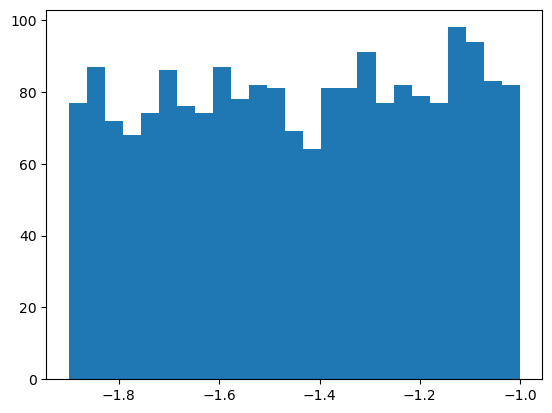

In [57]:
hist = plt.hist(mej_list, bins=25)

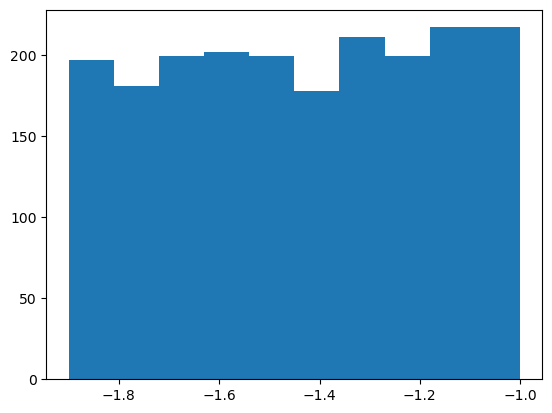

: 

In [ ]:
mej_list = []
vej_list = []
xlan_list = []

for i in range(len(param_shifted_paper)):
    mej = param_shifted_paper[i][0][0][0]
    vej = param_shifted_paper[i][0][0][1]
    xlan = param_shifted_paper[i][0][0][2]
    mej_list.append(mej)
    vej_list.append(vej)
    xlan_list.append(xlan)

hist = plt.hist(mej_list)

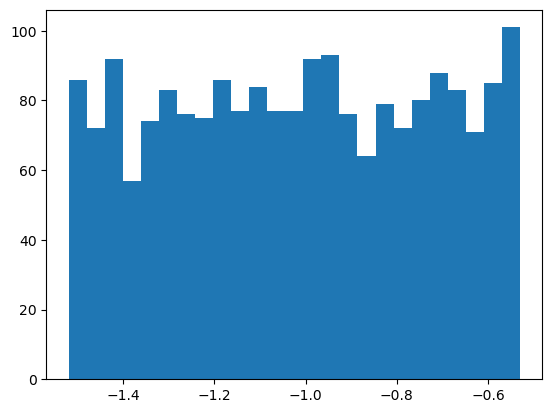

: 

In [ ]:
hist = plt.hist(vej_list, bins=25)

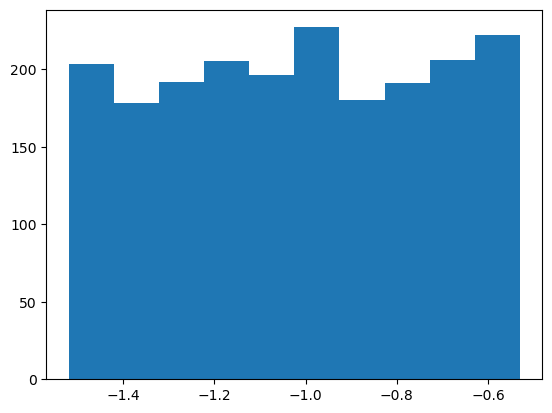

In [58]:
hist = plt.hist(vej_list)

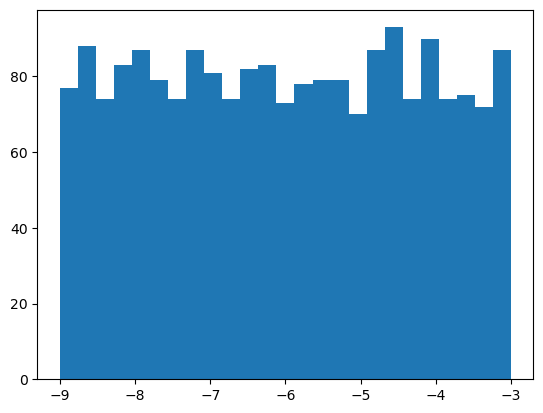

In [59]:
ist = plt.hist(xlan_list, bins=25)

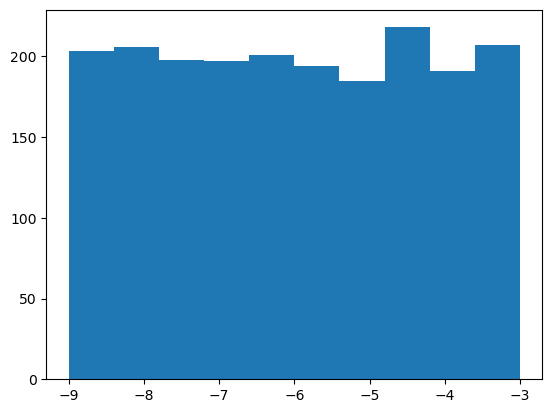

In [60]:
hist = plt.hist(xlan_list)

In [61]:
dist_list = []
shift_list = []

for i in range(len(param_shifted_paper)):
    for j in range(0, 50):
        dist = param_shifted_paper[i][j][0][4]
        shift = param_shifted_paper[i][j][0][3]
        dist_list.append(dist)
        shift_list.append(shift)

In [ ]:
print(param_shifted_paper[0][20][0][3])

tensor(-1.5362)


: 

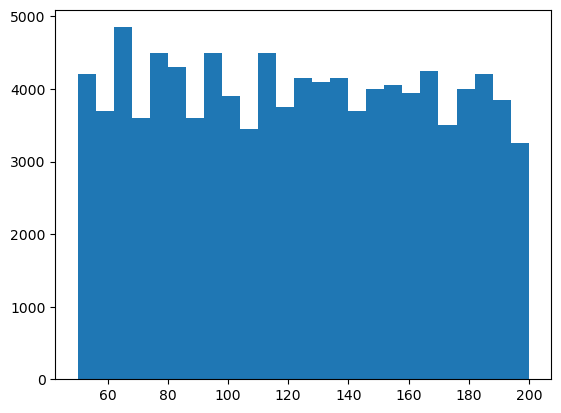

: 

In [ ]:
hist = plt.hist(dist_list, bins = 25)

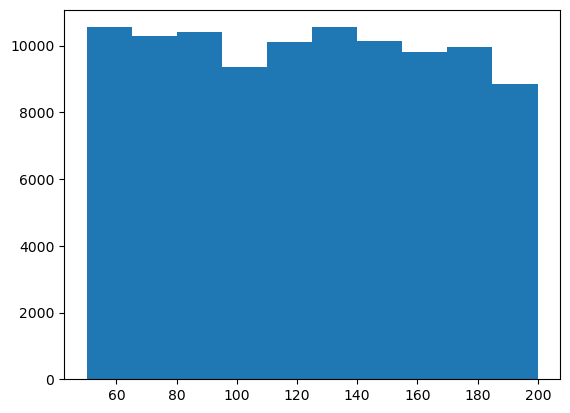

In [62]:
hist = plt.hist(dist_list)


In [ ]:
param_shifted_paper[0]

tensor([[[-1.1206e+00, -1.3497e+00, -6.5155e+00, -3.6657e-01,  5.5820e+01]],

        [[-1.1206e+00, -1.3497e+00, -6.5155e+00,  2.0088e+00,  5.5820e+01]],

        [[-1.1206e+00, -1.3497e+00, -6.5155e+00,  1.7314e+00,  5.5820e+01]],

        [[-1.1206e+00, -1.3497e+00, -6.5155e+00,  4.2494e+00,  5.5820e+01]],

        [[-1.1206e+00, -1.3497e+00, -6.5155e+00, -1.4901e+00,  5.5820e+01]],

        [[-1.1206e+00, -1.3497e+00, -6.5155e+00,  2.4329e+00,  5.5820e+01]],

        [[-1.1206e+00, -1.3497e+00, -6.5155e+00,  3.2083e+00,  5.5820e+01]],

        [[-1.1206e+00, -1.3497e+00, -6.5155e+00, -1.2565e+00,  5.5820e+01]],

        [[-1.1206e+00, -1.3497e+00, -6.5155e+00,  4.9528e+00,  5.5820e+01]],

        [[-1.1206e+00, -1.3497e+00, -6.5155e+00, -1.4014e+00,  5.5820e+01]],

        [[-1.1206e+00, -1.3497e+00, -6.5155e+00,  1.7992e+00,  5.5820e+01]],

        [[-1.1206e+00, -1.3497e+00, -6.5155e+00,  2.2741e+00,  5.5820e+01]],

        [[-1.1206e+00, -1.3497e+00, -6.5155e+00,  4.3624e+00,  5

: 

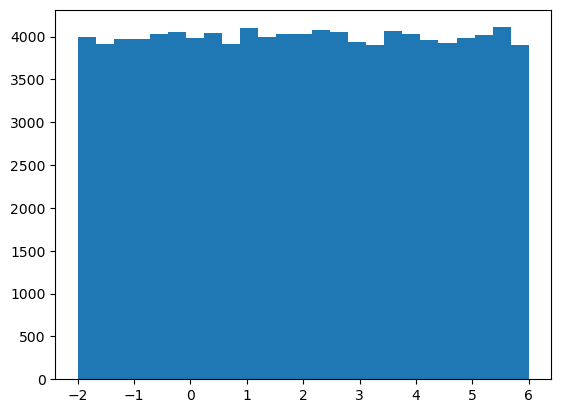

In [63]:
hist = plt.hist(shift_list, bins=25)

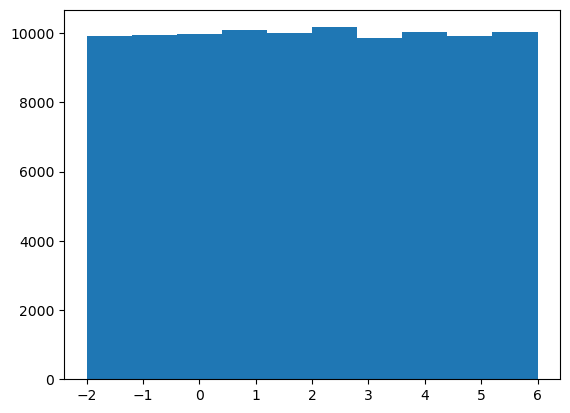

In [64]:
hist = plt.hist(shift_list)

## Light Curve Graphs

Some plotting codes for visualizing the light curves from the .csv files -- SKIP FOR NOW

In [66]:

fixed_colors = ['seagreen', 'crimson', 'blue']
varied_colors = ['mediumaquamarine', 'salmon', 'skyblue']
label_list = ['g band', 'r band', 'i band']
bands = ['ztfg', 'ztfr', 'ztfi']

def varied_fixed_plot(varied_df, fixed_df, sim_id, xlim_min=None, xlim_max=None, title = False, bands=bands):
    varied_data = varied_df.loc[varied_df['sim_id'] == sim_id]
    fixed_data = fixed_df.loc[fixed_df['sim_id'] == sim_id]
    if 'mej' in varied_data.columns:
        mej = varied_data.iloc[0, varied_data.columns.get_loc('mej')]
    if 'vej' in varied_data.columns:
        vej = varied_data.iloc[0, varied_data.columns.get_loc('vej')]
    if 'xlan' in varied_data.columns:
        xlan = varied_data.iloc[0, varied_data.columns.get_loc('xlan')]
    fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(7,7))
    for i in range(len(bands)):
        axs[i].scatter(fixed_data['t'], fixed_data[bands[i]], label = 'fixed, ' + label_list[i] , color = fixed_colors[i], s = 10)
        axs[i].scatter(varied_data['t'], varied_data[bands[i]], label = 'shifted, ' + label_list[i], color = varied_colors[i], s = 10)
        plt.gca().invert_yaxis()
        axs[i].legend()
        if (xlim_min != None) & (xlim_max != None):
            plt.xlim(xlim_min, xlim_max)
    fig.supxlabel('Time (Days)')
    fig.supylabel('Magnitude')
    if title == True:
        if ('vej' in varied_data.columns) and ('mej' in varied_data.columns):
            fig.suptitle('Light Curve for $\log_{{10}}(M_{{ej}})$: {:.2f}, $\log_{{10}}(V_{{ej}})$: {:.2f}, \n$\log_{{10}}(X_{{lan}})$: {:.2f}'.format(mej, vej, xlan), 
                         fontsize = 15)
    else:
        pass
    if 'shift' in varied_data.columns:
        shift = varied_data.iloc[0, varied_data.columns.get_loc('shift')]
    if 'distance' in varied_data.columns:
        distance = varied_data.iloc[0, varied_data.columns.get_loc('distance')]
    print(shift, distance)
    plt.show()

1.7313888437681575 55.820181778288145


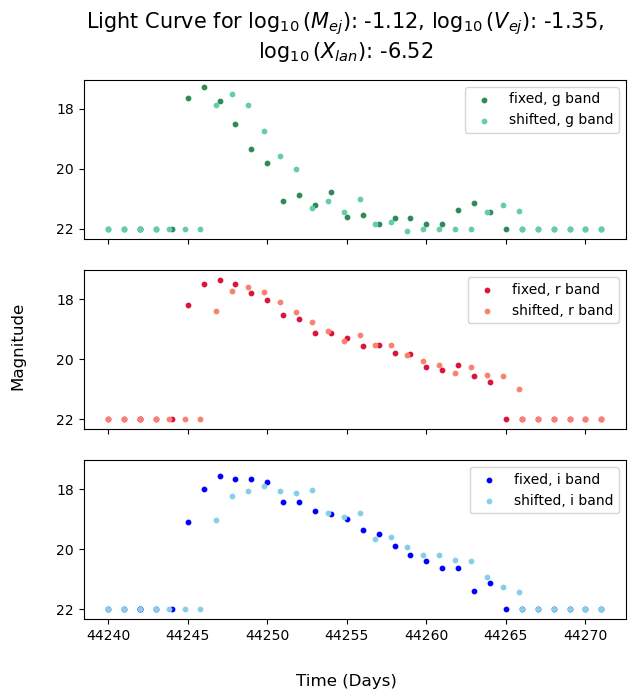

In [67]:
varied_fixed_plot(df_varied, df_fixed, 2,title = True)

# Similarity Embedding

In [68]:
# puts the neural network on the gpu
similarity_embedding = SimilarityEmbedding(num_dim=7, num_hidden_layers_f=1, num_hidden_layers_h=1, num_blocks=4, kernel_size=5, num_dim_final=5).to(device)
num_dim = 7

# optimizes
optimizer = optim.Adam(similarity_embedding.parameters(), lr=2.747064325271709e-05)

# sets learning rate steps
scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5) #constant lr
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=2e-3) #one cycle - increase and then decrease
scheduler_3 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 15])

In [69]:
# check if data is the right shape for similarity embedding

for var_inj_se, fix_inj_se, var_data_se, fix_data_se in train_data_loader_paper:
    var_inj_se = var_inj_se.reshape((-1,)+var_inj_se.shape[2:])
    fix_inj_se = fix_inj_se.reshape((-1,)+fix_inj_se.shape[2:])
    var_data_se = var_data_se.reshape((-1,)+var_data_se.shape[2:])
    fix_data_se = fix_data_se.reshape((-1,)+fix_data_se.shape[2:])
    break
var_inj_se.shape, var_data_se.shape, fix_inj_se.shape, fix_data_se.shape

(torch.Size([2500, 1, 5]),
 torch.Size([2500, 3, 33]),
 torch.Size([2500, 1, 5]),
 torch.Size([2500, 3, 33]))

In [70]:
# checking the shapes

embed, rep = similarity_embedding(var_data_se)
embed.shape, rep.shape

(torch.Size([2500, 5]), torch.Size([2500, 7]))

In [71]:
# embed the data and calculate the loss for one example to check for bugs

emb_aug, rep_aug = similarity_embedding(var_data_se)
emb_orig, rep_orig = similarity_embedding(fix_data_se)
vicreg_loss(emb_aug, emb_orig)

(tensor(0.9894, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(3.2989e-05, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(5.9235e-05, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.9893, device='cuda:0', grad_fn=<AddBackward0>))

In [72]:
# print neural network parameters that require gradients and sum parameters

sum_param=0
for name, param in similarity_embedding.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.numel())
        sum_param+=param.numel()
print(sum_param)

layer_norm.weight
363
layer_norm.bias
363
layers_f.conv1.weight
1344
layers_f.bn1.weight
64
layers_f.bn1.bias
64
layers_f.residual_layers.0.0.conv1.weight
20480
layers_f.residual_layers.0.0.bn1.weight
64
layers_f.residual_layers.0.0.bn1.bias
64
layers_f.residual_layers.0.0.conv2.weight
20480
layers_f.residual_layers.0.0.bn2.weight
64
layers_f.residual_layers.0.0.bn2.bias
64
layers_f.residual_layers.0.1.conv1.weight
20480
layers_f.residual_layers.0.1.bn1.weight
64
layers_f.residual_layers.0.1.bn1.bias
64
layers_f.residual_layers.0.1.conv2.weight
20480
layers_f.residual_layers.0.1.bn2.weight
64
layers_f.residual_layers.0.1.bn2.bias
64
layers_f.residual_layers.1.0.conv1.weight
40960
layers_f.residual_layers.1.0.bn1.weight
128
layers_f.residual_layers.1.0.bn1.bias
128
layers_f.residual_layers.1.0.conv2.weight
81920
layers_f.residual_layers.1.0.bn2.weight
128
layers_f.residual_layers.1.0.bn2.bias
128
layers_f.residual_layers.1.0.downsample.0.weight
8192
layers_f.residual_layers.1.0.downsamp

In [73]:
# write to tensorboard for data visualization

writer = SummaryWriter("torchlogs/")
model = similarity_embedding
writer.add_graph(model, var_data_se)
writer.close()

In [74]:
%%time
# training the neural network for many epochs

epoch_number = 0
EPOCHS = 50

sim_val_loss = []
sim_train_loss = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # set the vicreg weights
    wt_repr, wt_cov, wt_std = (1, 1, 1) #Change the weights as needed for a first few starting epochs
    print(f"VicReg wts: {wt_repr} {wt_cov} {wt_std}")
    
    # Gradient tracking
    similarity_embedding.train(True)
    avg_train_loss = train_one_epoch_se(epoch_number, writer, train_data_loader_paper,
                                        similarity_embedding, optimizer, vicreg_loss, verbose=True,
                                        wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    sim_train_loss.append(avg_train_loss)
    
    # no gradient tracking, for validation
    similarity_embedding.train(False)
    similarity_embedding.eval()
    avg_val_loss = val_one_epoch_se(epoch_number, writer, val_data_loader_paper,
                                    similarity_embedding, vicreg_loss,
                                    wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    sim_val_loss.append(avg_val_loss)
    
    print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

    epoch_number += 1
    scheduler.step()


EPOCH 1:
VicReg wts: 1 1 1
 Avg. train loss/batch after 10 batches = 0.9880
Last 0.00; 0.00; 0.99
 Avg. train loss/batch after 20 batches = 0.9827
Last 0.00; 0.00; 0.98
 Avg. train loss/batch after 30 batches = 0.9750
Last 0.00; 0.00; 0.97
Train/Val Sim Loss after epoch: 0.9750/0.9682
EPOCH 2:
VicReg wts: 1 1 1
 Avg. train loss/batch after 10 batches = 0.9628
Last 0.01; 0.00; 0.95
 Avg. train loss/batch after 20 batches = 0.9498
Last 0.01; 0.00; 0.93
 Avg. train loss/batch after 30 batches = 0.9343
Last 0.01; 0.00; 0.91
Train/Val Sim Loss after epoch: 0.9343/0.9183
EPOCH 3:
VicReg wts: 1 1 1
 Avg. train loss/batch after 10 batches = 0.9139
Last 0.03; 0.00; 0.88
 Avg. train loss/batch after 20 batches = 0.8934
Last 0.03; 0.00; 0.84
 Avg. train loss/batch after 30 batches = 0.8705
Last 0.05; 0.00; 0.80
Train/Val Sim Loss after epoch: 0.8705/0.8454
EPOCH 4:
VicReg wts: 1 1 1
 Avg. train loss/batch after 10 batches = 0.8449
Last 0.07; 0.00; 0.76
 Avg. train loss/batch after 20 batches = 0.

/home/oppenheimer/miniconda3/envs/ML/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 Avg. train loss/batch after 10 batches = 0.6276
Last 0.14; 0.01; 0.42
 Avg. train loss/batch after 20 batches = 0.4973
Last 0.19; 0.00; 0.24
 Avg. train loss/batch after 30 batches = 0.3694
Last 0.23; 0.01; 0.17
Train/Val Sim Loss after epoch: 0.3694/0.2147
EPOCH 7:
VicReg wts: 1 1 1
 Avg. train loss/batch after 10 batches = 0.3995
Last 0.30; 0.01; 0.04
 Avg. train loss/batch after 20 batches = 0.2939
Last 0.25; 0.00; 0.00
 Avg. train loss/batch after 30 batches = 0.1856
Last 0.12; 0.01; 0.00
Train/Val Sim Loss after epoch: 0.1856/0.1140
EPOCH 8:
VicReg wts: 1 1 1
 Avg. train loss/batch after 10 batches = 0.4927
Last 0.33; 0.01; 0.08
 Avg. train loss/batch after 20 batches = 0.3729
Last 0.24; 0.01; 0.15
 Avg. train loss/batch after 30 batches = 0.2104
Last 0.11; 0.01; 0.00
Train/Val Sim Loss after epoch: 0.2104/0.1157
EPOCH 9:
VicReg wts: 1 1 1
 Avg. train loss/batch after 10 batches = 0.3027
Last 0.02; 0.03; 0.68
 Avg. train loss/batch after 20 batches = 0.8766
Last 0.00; 0.00; 0.99


Text(0, 0.5, 'Loss')

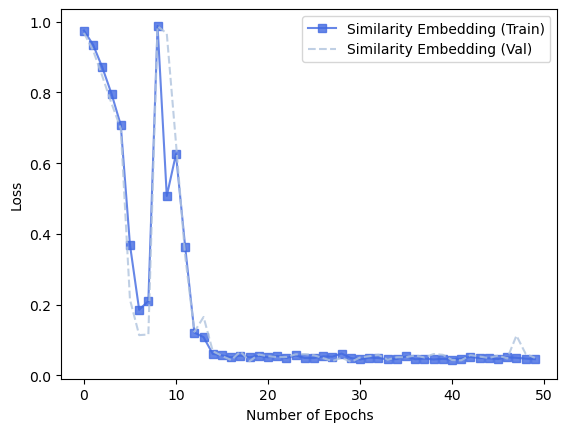

In [75]:
# plot the train/val loss 

epoch_list = range(0,len(sim_train_loss))
plt.plot(epoch_list, sim_train_loss, label = 'Similarity Embedding (Train)', color = 'royalblue', alpha = 0.8, marker = 's')
plt.plot(epoch_list, sim_val_loss, label = 'Similarity Embedding (Val)', color = 'lightsteelblue', alpha=0.8, linestyle="dashed")
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

## Saving Embedding Weights

In [76]:
# save the embedded weights (input your save path)

SAVEPATH = '/home/oppenheimer/summer2025/Kilo/weights/similarity-embedding-weights-tutorial2.pth'
torch.save(similarity_embedding.state_dict(), SAVEPATH)

# Loading Embedding Weights

If you do not want to retrain the embedding, just load the pretrained weights here: 

In [75]:
# load the weights 

similarity_embedding = SimilarityEmbedding(num_dim=7, num_hidden_layers_f=1, num_hidden_layers_h=1, num_blocks=4, kernel_size=5, num_dim_final=5).to(device)
num_dim = 7

SAVEPATH = '/home/oppenheimer/summer2025/Kilo/weights/similarity-embedding-weights-tutorial2.pth'
similarity_embedding.load_state_dict(torch.load(SAVEPATH, map_location=device))

/tmp/ipykernel_1404/1060766579.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  similarity_embedding.load_state_dict(torch.load(SAVEPATH, map_location=device))


RuntimeError: Error(s) in loading state_dict for SimilarityEmbedding:
	size mismatch for contraction_layer.weight: copying a param with shape torch.Size([3, 100]) from checkpoint, the shape in current model is torch.Size([7, 100]).
	size mismatch for contraction_layer.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([7]).
	size mismatch for expander_layer.weight: copying a param with shape torch.Size([100, 3]) from checkpoint, the shape in current model is torch.Size([100, 7]).

# Visualizing the embedding for all test cases

In [148]:
similarity_embedding.train(False)
data_loader = test_data_loader_paper

similarity_outputs_1 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1) and (shift_test[0][0][0] > -1.25)):
        continue
    if not ((shift_test[0][0][1] < -0.5) and (shift_test[0][0][1] > -0.75)):
        continue
    if not ((shift_test[0][0][2] < -3) and (shift_test[0][0][2] > -4.5)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1.25) and (shift_test[0][0][0] > -1.5)):
        continue
    if not ((shift_test[0][0][1] < -0.75) and (shift_test[0][0][1] > -1)):
        continue
    if not ((shift_test[0][0][2] < -4.5) and (shift_test[0][0][2] > -6)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output)

similarity_outputs_3 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1.5) and (shift_test[0][0][0] > -1.75)):
        continue
    if not ((shift_test[0][0][1] < -1) and (shift_test[0][0][1] > -1.25)):
        continue
    if not ((shift_test[0][0][2] < -6) and (shift_test[0][0][2] > -7.5)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_3.append(similarity_output)

similarity_outputs_4 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1.75) and (shift_test[0][0][0] > -2.5)):
        continue
    if not ((shift_test[0][0][1] < -1.25) and (shift_test[0][0][1] > -1.55)):
        continue
    if not ((shift_test[0][0][2] < -7.5) and (shift_test[0][0][2] > -9)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_4.append(similarity_output)



In [149]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_3 = torch.stack(similarity_outputs_3)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

RuntimeError: stack expects a non-empty TensorList

In [150]:
similarity_outputs_1.shape, similarity_outputs_2.shape, similarity_outputs_3.shape, similarity_outputs_4.shape

AttributeError: 'list' object has no attribute 'shape'

AttributeError: 'list' object has no attribute 'cpu'

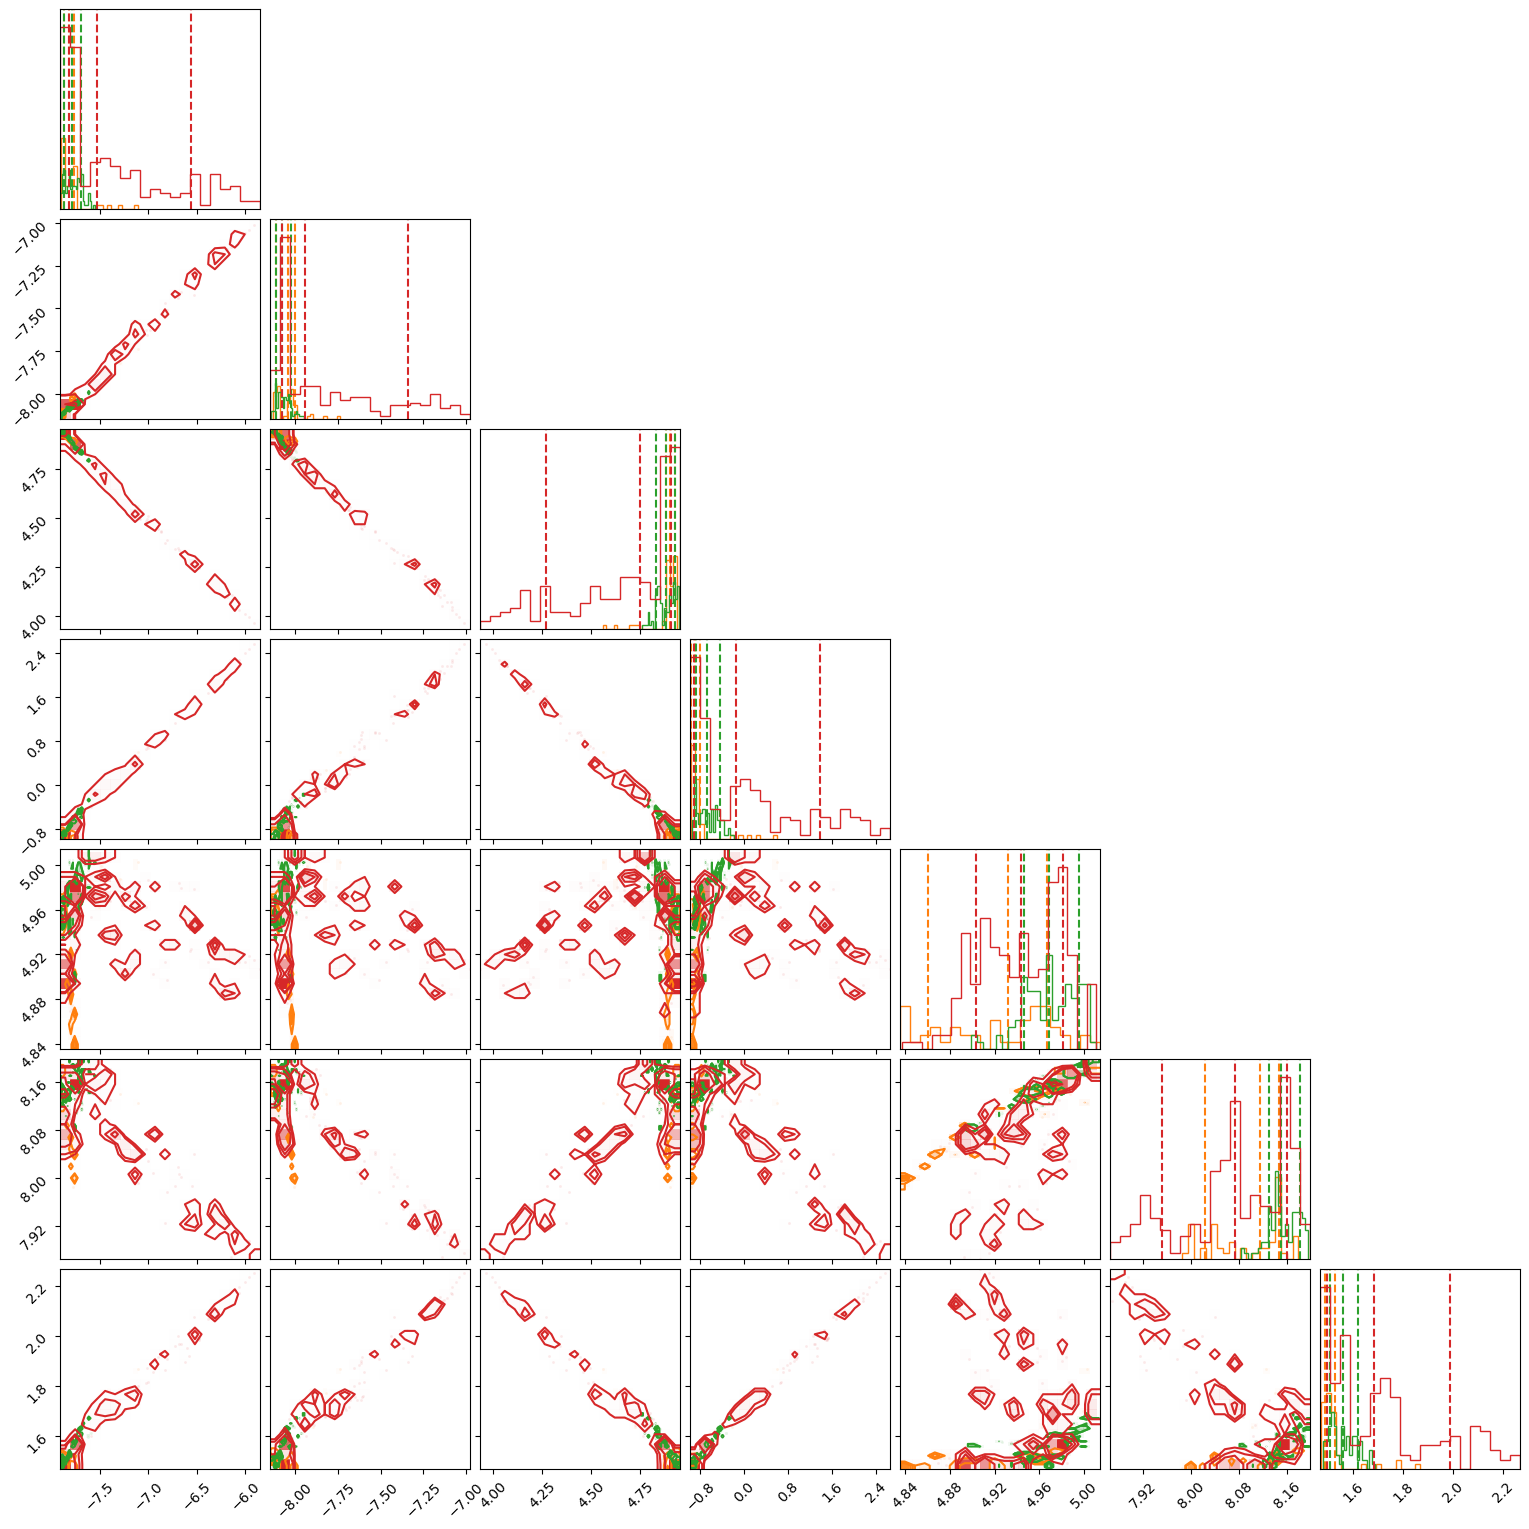

In [151]:
figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)
c1_line = mlines.Line2D([], [], color='C1', 
                            label='-1 > $\log_{{10}}(M_{{ej}})$ > -1.25, -0.5 > $\log_{{10}}(V_{{ej}})$ > -0.75, -3.0 > $\log_{{10}}(X_{{lan}})$ > -4.5')

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, 
    color="C2", # range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)
c2_line = mlines.Line2D([], [], color='C2', 
                            label='-1.25 > $\log_{{10}}(M_{{ej}})$ > -1.5, -0.75 > $\log_{{10}}(V_{{ej}})$ > -1.0, -4.5 > $\log_{{10}}(X_{{lan}})$ > -6.0')

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)
c3_line = mlines.Line2D([], [], color='C3', 
                            label='-1.5 > $\log_{{10}}(M_{{ej}})$ > -1.75, -1.0 > $\log_{{10}}(V_{{ej}})$ > -1.25, -6.0 > $\log_{{10}}(X_{{lan}})$ > -7.5')

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)
c4_line = mlines.Line2D([], [], color='C4', 
                            label='-1.75 > $\log_{{10}}(M_{{ej}})$ > -1.9, -1.25 > $\log_{{10}}(V_{{ej}})$ > -1.53, -7.5 > $\log_{{10}}(X_{{lan}})$ > -9.0')

plt.legend(handles=
           [c1_line, c2_line, c3_line, c4_line],
           bbox_to_anchor=(0.3, 7.3),
           fontsize = 18
          )

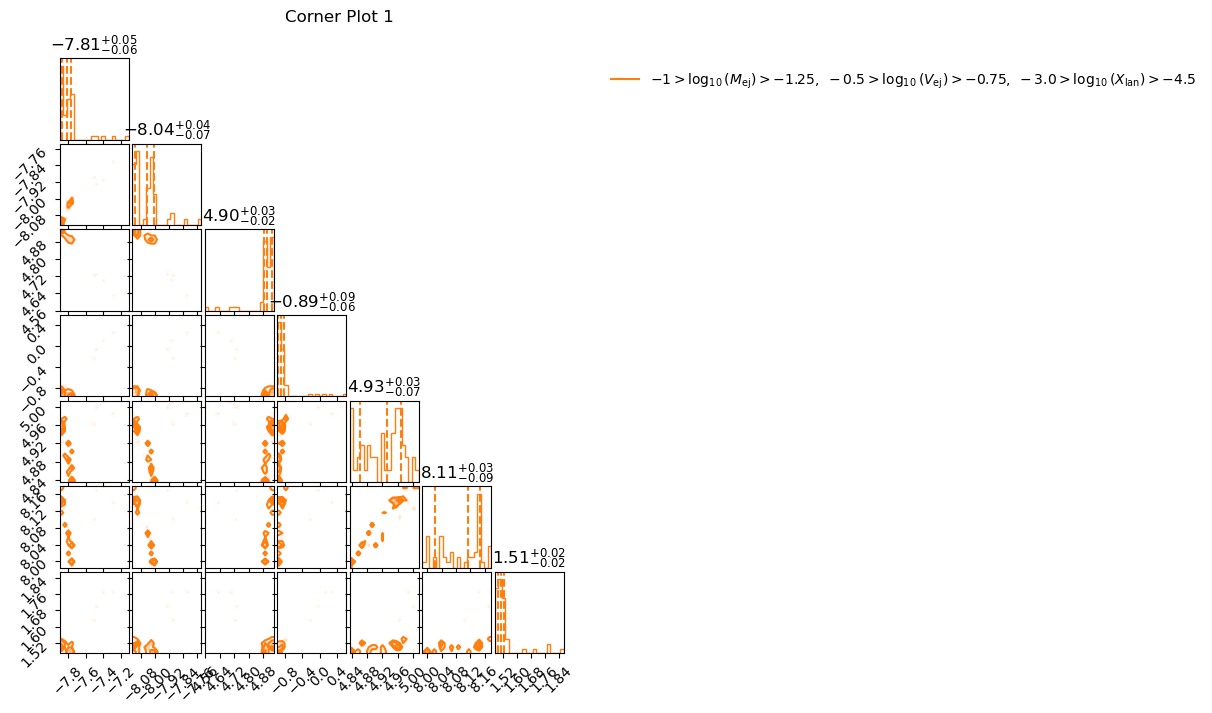

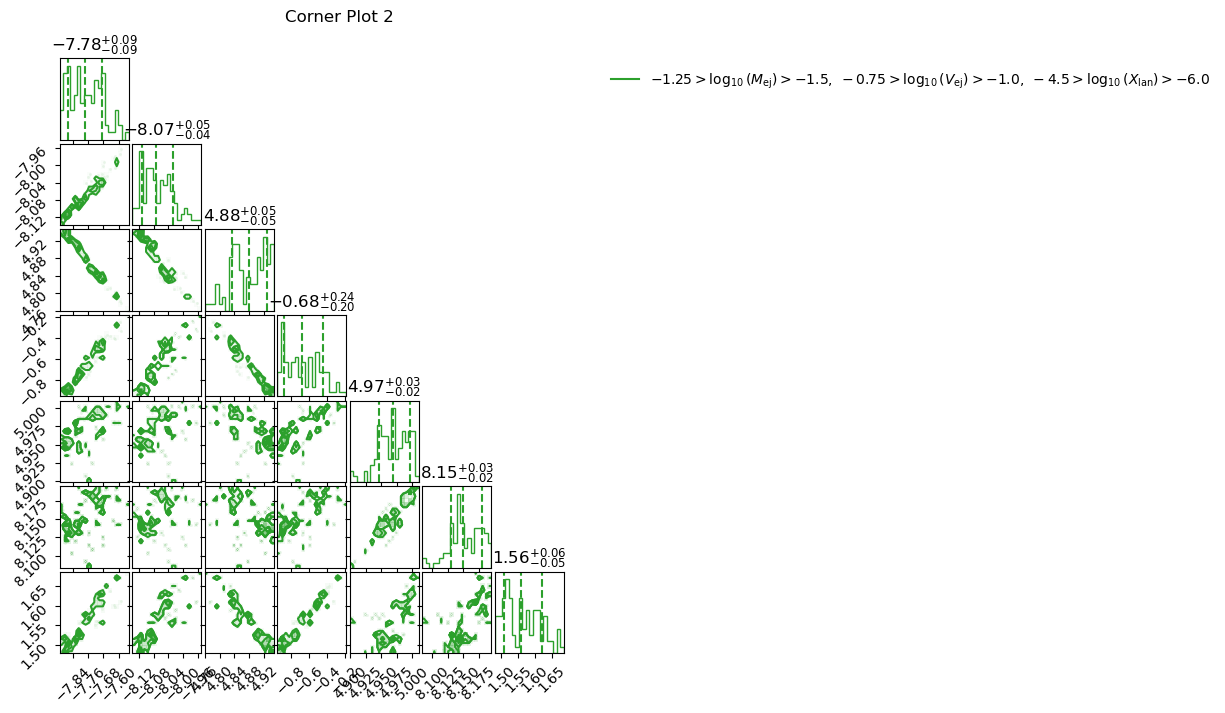

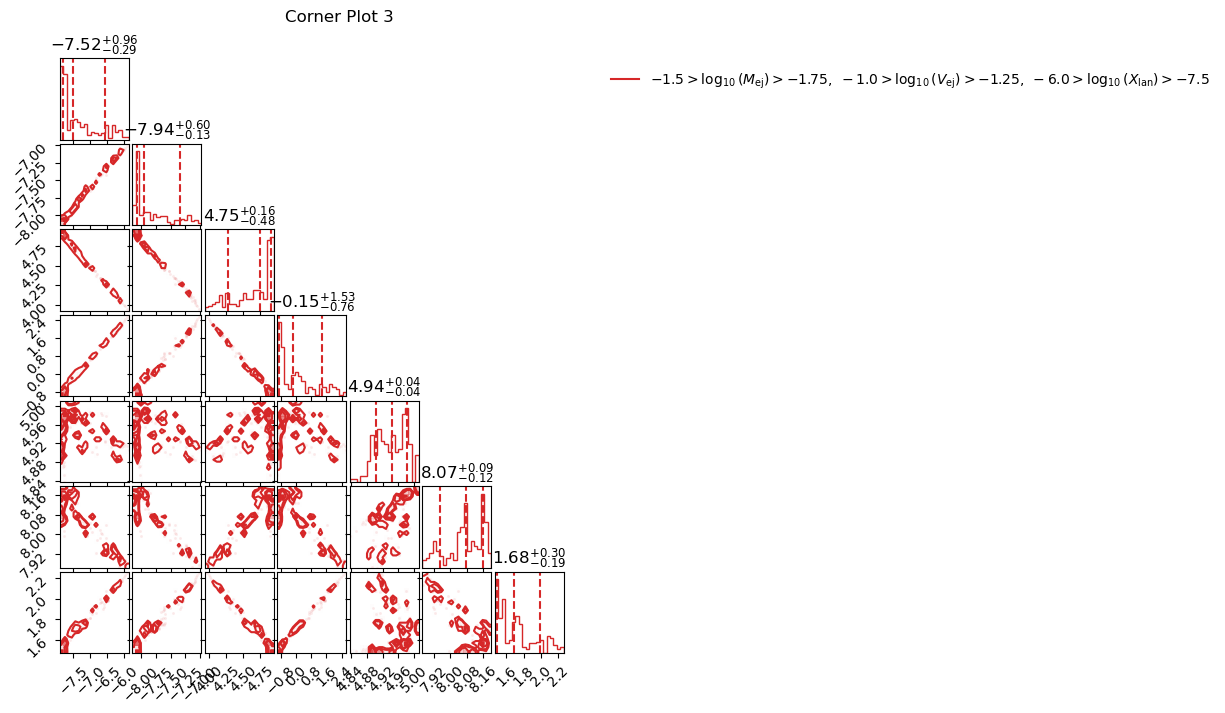

AttributeError: 'list' object has no attribute 'cpu'

In [152]:
import matplotlib.pyplot as plt
import corner
import matplotlib.lines as mlines

datasets = [
    similarity_outputs_1,
    similarity_outputs_2,
    similarity_outputs_3,
    similarity_outputs_4,
]
colors = ["C1", "C2", "C3", "C4"]
labels = [
    r"$-1 > \log_{10}(M_{\rm ej}) > -1.25,\;-0.5 > \log_{10}(V_{\rm ej}) > -0.75,\;-3.0 > \log_{10}(X_{\rm lan}) > -4.5$",
    r"$-1.25 > \log_{10}(M_{\rm ej}) > -1.5,\;-0.75 > \log_{10}(V_{\rm ej}) > -1.0,\;-4.5 > \log_{10}(X_{\rm lan}) > -6.0$",
    r"$-1.5 > \log_{10}(M_{\rm ej}) > -1.75,\;-1.0 > \log_{10}(V_{\rm ej}) > -1.25,\;-6.0 > \log_{10}(X_{\rm lan}) > -7.5$",
    r"$-1.75 > \log_{10}(M_{\rm ej}) > -1.9,\;-1.25 > \log_{10}(V_{\rm ej}) > -1.53,\;-7.5 > \log_{10}(X_{\rm lan}) > -9.0$",
]

for idx, (data, color, label) in enumerate(zip(datasets, colors, labels), start=1):
    arr = data.cpu().numpy().reshape(-1, num_dim)

    # 1) make a new, reasonably‐sized figure
    fig = plt.figure(figsize=(7, 7))

    # 2) draw the corner plot into it
    corner.corner(
        arr,
        fig=fig,
        quantiles=[0.16, 0.5, 0.84],
        color=color,
        show_titles=True,
        title_fmt=".2f",
    )

    # 3) create a single Line2D for the legend
    line = mlines.Line2D([], [], color=color, label=label)

    # 4) shrink the plotting area to make room for the legend on the right
    #    the [left, bottom, right, top] rectangle keeps most of the figure
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.82, top=0.95)

    # 5) place the legend inside that right margin
    fig.legend(
        handles=[line],
        loc="upper left",
        bbox_to_anchor=(0.87, 0.95),
        fontsize=10,
        frameon=False,
    )

    plt.suptitle(f"Corner Plot {idx}", y=1.02)
    plt.show()




# Normalizing Flow Training Data

### Varied Data

In [ ]:
varied_normflow_dict = {}

In [ ]:
# get the varied data

norm_path = '/nobackup/users/mmdesai/lowcflowdata'
num_sims = 25000

normflow_num_lc_list = [25000, 25000, 25000, 24843, 25000, 24917, 25000, 25000, 24706, 25000]

for i in range(3, 10):
    # get the names of each file
    file_names = get_names(norm_path, 'varied', i, normflow_num_lc_list[i])
    # open the files as dataframes
    varied_normflow_dict['varied_normflow_data_{}'.format(i)] = json_to_df(file_names, normflow_num_lc_list[i])
    # pad the data
    varied_normflow_dict['varied_normflow_data_{}'.format(i)] = pad_all_dfs(varied_normflow_dict['varied_normflow_data_{}'.format(i)])

In [ ]:
varied_normflow_dict['varied_normflow_data_0'][0]

In [ ]:
for i in range(0, 50):
    plt.scatter(varied_normflow_dict['varied_normflow_data_0'][i]['t'], varied_normflow_dict['varied_normflow_data_0'][i]['ztfg'], color = 'g')
    plt.scatter(varied_normflow_dict['varied_normflow_data_0'][i]['t'], varied_normflow_dict['varied_normflow_data_0'][i]['ztfr'], color = 'r')
    plt.scatter(varied_normflow_dict['varied_normflow_data_0'][i]['t'], varied_normflow_dict['varied_normflow_data_0'][i]['ztfi'], color = 'c')
plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')

In [ ]:
# injection files

varied_normflow_inj_dict = {}
inj_path_normflow = '/nobackup/users/mmdesai/final_injections/'

for i in range(0, 10):
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)] = pd.DataFrame()
    varied_params = open_json('injection_normflow_varied_{}.json'.format(i), inj_path_normflow)
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['mej'] = varied_params['injections']['content']['log10_mej']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['vej'] = varied_params['injections']['content']['log10_vej']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['xlan'] = varied_params['injections']['content']['log10_Xlan']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['shift'] = varied_params['injections']['content']['timeshift']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['distance'] = varied_params['injections']['content']['luminosity_distance']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['sim_id'] = varied_params['injections']['content']['simulation_id']

In [ ]:
varied_normflow_inj_dict['varied_inj_df0']

In [ ]:
# concatenate dataframe lists

all_varied_data_list_flow = [0] * 10

for i in range(0, 10):
    all_varied_data_list_flow[i] = pd.concat(varied_normflow_dict['varied_normflow_data_{}'.format(i)])

In [ ]:
# merge with injection parameters

all_varied_datawparams_list_flow = [0] * 10

for i in range(0, 10):
    all_varied_datawparams_list_flow[i] = all_varied_data_list_flow[i].merge(varied_normflow_inj_dict['varied_inj_df{}'.format(i)], on = 'sim_id')
    # save as csv file
    all_varied_datawparams_list_flow[i].to_csv('/nobackup/users/mmdesai/final_csv/flow_varied_lowc_{}.csv'.format(i), index = False)

In [ ]:
all_varied_datawparams_list_flow[0]

# Data Processing


In [87]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
dir_path        = "/home/oppenheimer/summer2025/Kilo/norm_data/"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 5000        # how many sims to process per batch
batch_size      = 50          # sims per batch for batch_id
output_csv      = "/home/oppenheimer/summer2025/Kilo/csv files/norm_flow_data.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
t_min = np.floor(raw_min)
t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_all = pd.read_csv(output_csv)
print("Final table shape:", df_all.shape)
print("Time spans:", df_all['t'].min(), "→", df_all['t'].max())
print("Unique batch_ids:", sorted(df_all['batch_id'].unique()))


100%|██████████| 5000/5000 [00:06<00:00, 803.62it/s]


Final table shape: (3300000, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,

In [112]:
output_csv = "/home/oppenheimer/summer2025/Kilo/csv files/norm_flow_data.csv"

df_all = pd.read_csv(output_csv)
print("Final table shape:", df_all.shape)
print("Time spans:", df_all['t'].min(), "→", df_all['t'].max())
print("Unique batch_ids:", sorted(df_all['batch_id'].unique()))

Final table shape: (3300000, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,

In [113]:
sim_id = 10  # change this to the sim_id you want to inspect
df_sim = df_all[df_all['sim_id'] == sim_id]
print(f"Data for sim_id {sim_id}:\n", df_sim)

Data for sim_id 10:
                t       ztfg       ztfr       ztfi  sim_id  num_detections  \
330  44240.00000  22.000000  22.000000  22.000000      10              25   
331  44241.00000  22.000000  22.000000  22.000000      10              25   
332  44242.00000  22.000000  22.000000  22.000000      10              25   
333  44242.30806  22.000000  22.000000  22.000000      10              25   
334  44243.30806  22.000000  22.000000  22.000000      10              25   
335  44244.30806  22.000000  22.000000  22.000000      10              25   
336  44245.30806  19.508563  19.780622  20.249695      10              25   
337  44246.30806  20.433852  19.754635  20.129965      10              25   
338  44247.30806  21.330657  19.855109  19.795716      10              25   
339  44248.30806  21.608494  20.156466  20.499803      10              25   
340  44249.30806  22.000000  20.452983  20.783812      10              25   
341  44250.30806  22.000000  20.466415  21.481275      

In [114]:
inj_path_simembed = '/home/oppenheimer/summer2025/Kilo/norm_data/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

            mej       vej      xlan     shift    distance  sim_id
0     -1.492051 -0.994376 -7.225461  0.660475  181.087825       0
1     -1.492051 -0.994376 -7.225461 -0.291725  181.087825       1
2     -1.492051 -0.994376 -7.225461  5.295663  181.087825       2
3     -1.492051 -0.994376 -7.225461 -1.172442  181.087825       3
4     -1.492051 -0.994376 -7.225461  2.151297  181.087825       4
...         ...       ...       ...       ...         ...     ...
99995 -1.445593 -0.536553 -7.895044 -0.433082  167.709758   99995
99996 -1.445593 -0.536553 -7.895044  1.579749  167.709758   99996
99997 -1.445593 -0.536553 -7.895044  0.466668  167.709758   99997
99998 -1.445593 -0.536553 -7.895044  1.904476  167.709758   99998
99999 -1.445593 -0.536553 -7.895044  2.017853  167.709758   99999

[100000 rows x 6 columns]


In [115]:
# if your varied_injections DataFrame calls its sim key something else, rename it:
# varied_injections = varied_injections.rename(columns={ 'simulation_id': 'sim_id' })

# select only the columns you care about from injections
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final = df_all.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final.shape)  # should be (~3 300 000, original_cols+5)


Final shape: (3300000, 12)


In [116]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_norm = df_final[desired_order]

In [117]:
data_shifted_flow, param_shifted_flow = test_df_to_tensor(df_norm, 2000, 50)

100%|██████████| 2000/2000 [00:16<00:00, 122.33it/s]


# Load in the Data

ONLY CSV

In [ ]:
data_dir_flow = '/nobackup/users/mmdesai/final_csv/'

In [ ]:
df_flow1 = load_in_data(data_dir_flow, 'flow_varied', 10) 

In [ ]:
df_flow1

In [ ]:
detected_df1 = df_flow1.loc[df_flow1['num_detections'] >= 20]
detected_df1

In [ ]:
# varied

detected_df1 = detected_df1.iloc[:29275950, :12]
add_batch_sim_nums_all(detected_df1)
detected_df1

In [ ]:
matched_df_flow2 = matched(data_dir_flow, 'flow_varied', 'flow_fixed', 10, 20) 

In [ ]:
new_df_flow2 = matched_df_flow2.loc[matched_df_flow2['mej_x'] >= -1.9].copy()
new_df_flow2

In [ ]:
detected_df2 = new_df_flow2.loc[new_df_flow2['num_detections_x'] >= 8]
detected_df2

In [ ]:
# varied

var_df = detected_df2.iloc[:27097950, :12]
var_df.columns = var_df.columns.str.rstrip('_x')
var_df = var_df.drop(columns=['key_1'])
add_batch_sim_nums_all(var_df)
var_df

In [ ]:
# fixed

fix_df = detected_df2.iloc[:27097950, 12:]
fix_df.columns = fix_df.columns.str.rstrip('_y')
add_batch_sim_nums_all(fix_df)
fix_df

In [ ]:
matched_df_flow3 = matched(data_dir_flow, 'flow_varied', 'flow_fixed', 20, 30) 

In [ ]:
new_df_flow3 = matched_df_flow3.loc[matched_df_flow3['mej_x'] >= -1.9].copy()
new_df_flow3

In [ ]:
detected_df3 = new_df_flow3.loc[new_df_flow3['num_detections_x'] >= 8]
detected_df3

In [ ]:
# varied

var_df = detected_df3.iloc[:27073750, :12]
var_df.columns = var_df.columns.str.rstrip('_x')
var_df = var_df.drop(columns=['key_1'])
add_batch_sim_nums_all(var_df)
var_df

In [ ]:
# fixed

fix_df = detected_df3.iloc[:27073750, 12:]
fix_df.columns = fix_df.columns.str.rstrip('_y')
add_batch_sim_nums_all(fix_df)
fix_df

In [ ]:
plt.hist(var_df['mej'])

In [ ]:
plt.hist(var_df['vej'])

In [ ]:
plt.hist(var_df['xlan'])

In [ ]:
plt.hist(var_df['distance'])

# Prep for Flow

In [ ]:
# moving the data from csv to tensors on gpu -- Don't run if tensors are already stored and available

num_lc_flow = len(detected_df1['batch_id'].unique())
data_shifted_flow, param_shifted_flow = test_df_to_tensor(detected_df1, num_lc_flow, 50)

In [ ]:
data_shifted_flow1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_flow4.pt')
data_unshifted_flow1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_flow4.pt')
param_shifted_flow1 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_flow4.pt')
param_unshifted_flow1 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_flow4.pt')

In [ ]:
data_shifted_flow2 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_flow7.pt')
data_unshifted_flow2 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_flow7.pt')
param_shifted_flow2 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_flow7.pt')
param_unshifted_flow2 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_flow7.pt')

In [ ]:
data_shifted_flow = torch.stack(data_shifted_flow1 + data_shifted_flow2)
param_shifted_flow = torch.stack(param_shifted_flow1 + param_shifted_flow2)

In [ ]:
num_lc_flow = len(data_shifted_flow)
print(num_lc_flow)

In [118]:
data_shifted_flow[0].shape, param_shifted_flow[0].shape

(torch.Size([50, 3, 33]), torch.Size([50, 1, 5]))

In [119]:
class Flow_data(Dataset):
    def __init__(self, data_shifted_flow, param_shifted_flow,num_lc_flow):
        super().__init__()
        self.data_shifted_flow = data_shifted_flow
        self.param_shifted_flow = param_shifted_flow
        self.num_lc_flow = num_lc_flow

    def __len__(self):
        return self.num_lc_flow

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return (
            self.param_shifted_flow[idx].to(device),
            self.data_shifted_flow[idx].to(device),
        )

In [120]:
num_lc_flow = 2000
dataset_normflow = Flow_data(data_shifted_flow, param_shifted_flow, num_lc_flow)

# check the dataset shape
t, d = dataset_normflow[4]
t.shape, d.shape

(torch.Size([50, 1, 5]), torch.Size([50, 3, 33]))

In [121]:
# split dataset into training, testing, and validation

train_set_size_flow = int(0.8 * num_lc_flow)    
val_set_size_flow = int(0.1 * num_lc_flow)     
test_set_size_flow = num_lc_flow - train_set_size_flow - val_set_size_flow

train_data_flow, val_data_flow, test_data_flow = torch.utils.data.random_split(
    dataset_normflow, [train_set_size_flow, val_set_size_flow, test_set_size_flow])

In [122]:
# load and shuffle the data

train_data_loader_flow = DataLoader(train_data_flow, batch_size=25, shuffle=True)
val_data_loader_flow = DataLoader(val_data_flow, batch_size=25, shuffle=True)
test_data_loader_flow = DataLoader(test_data_flow, batch_size=1, shuffle=False)

# check lengths
len(train_data_loader_flow), len(test_data_loader_flow), len(val_data_loader_flow)

(64, 200, 8)

In [123]:
# check first instance of data

for var_inj, var_data in train_data_loader_flow:
    var_inj = var_inj.reshape((-1,)+var_inj.shape[2:])
    var_data = var_data.reshape((-1,)+var_data.shape[2:])

    break
var_inj.shape, var_data.shape

(torch.Size([1250, 1, 5]), torch.Size([1250, 3, 33]))

# Histograms

In [166]:
mej_list = []
vej_list = []
xlan_list = []

for i in range(len(param_shifted_flow)):
    mej = param_shifted_flow[i][0][0][0]
    vej = param_shifted_flow[i][0][0][1]
    xlan = param_shifted_flow[i][0][0][2]
    mej_list.append(mej)
    vej_list.append(vej)
    xlan_list.append(xlan)

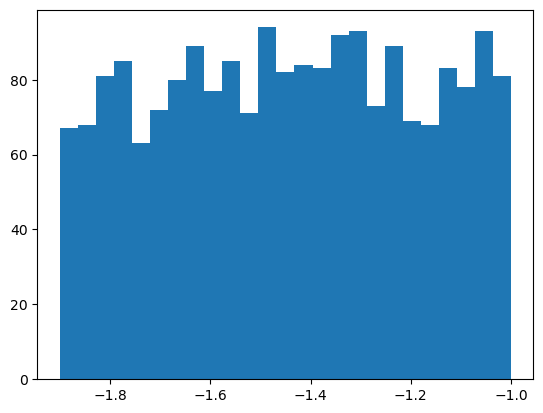

In [167]:
hist = plt.hist(mej_list, bins=25)

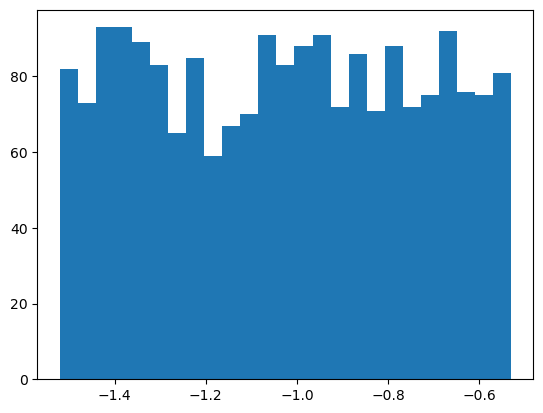

In [168]:
hist = plt.hist(vej_list, bins=25)

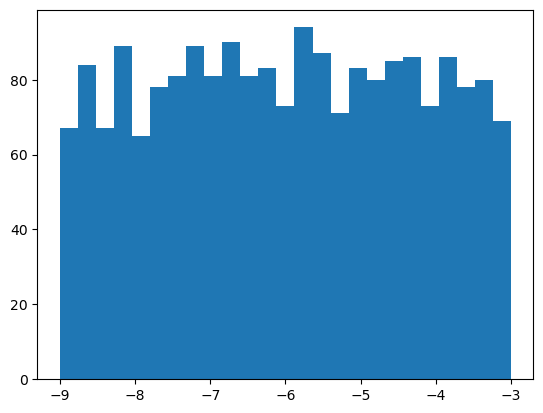

In [169]:
hist = plt.hist(xlan_list, bins=25)

In [170]:
dist_list = []
shift_list = []

for i in range(len(param_shifted_flow)):
    for j in range(0, 50):
        dist = param_shifted_flow[i][j][0][4]
        shift = param_shifted_flow[i][j][0][3]
        dist_list.append(dist)
        shift_list.append(shift)

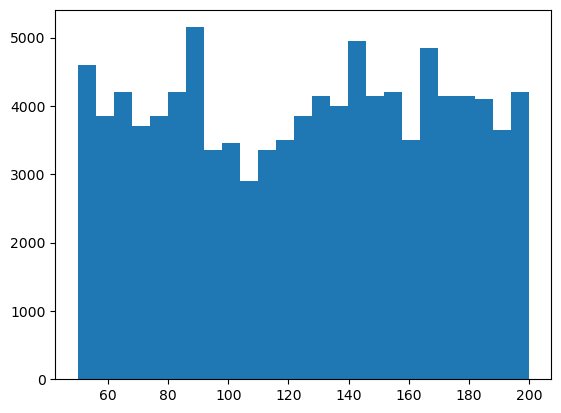

In [171]:
hist = plt.hist(dist_list, bins = 25)

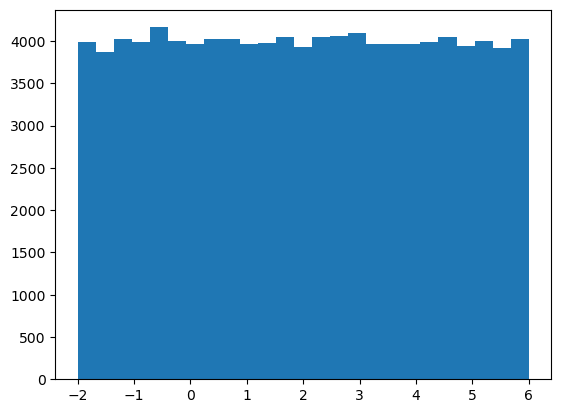

In [172]:
hist = plt.hist(shift_list, bins = 25)

# Partially Freeze the Similarity Embedding

In [124]:
for var_inj_se, var_data_se in train_data_loader_flow:
    var_inj_se = var_inj_se.reshape((-1,)+var_inj_se.shape[2:]).to(device)
    var_data_se = var_data_se.reshape((-1,)+var_data_se.shape[2:]).to(device)
    break

# check shapes
print(var_data_se.shape, var_inj_se.shape)
_, rep = similarity_embedding(var_data_se)  # _.shape = batch_size x 1 x 10, # rep.shape = batch_size x 1 x 2
print(_.shape, rep.shape)
context_features = rep.shape[-1]
print('number of context_features: ', context_features)
print('number of dimensions: ', num_dim)

torch.Size([1250, 3, 33]) torch.Size([1250, 1, 5])
torch.Size([1250, 5]) torch.Size([1250, 7])
number of context_features:  7
number of dimensions:  7


In [125]:
# define parameters

transform, base_dist, embedding_net = normflow_params(similarity_embedding, 9, 5, 90, context_features=context_features, num_dim=num_dim) 

In [126]:
flow = Flow(transform, base_dist, embedding_net).to(device=device)

In [127]:
print('Total number of trainable parameters: ', sum(p.numel() for p in flow.parameters() if p.requires_grad))

Total number of trainable parameters:  1204975


In [128]:
for idx, val in enumerate(train_data_loader_flow, 1):
    augmented_shift, augmented_data = val
    augmented_shift = augmented_shift[...,0:3].to(device)
    augmented_shift = augmented_shift.flatten(0, 2).to(device)
    augmented_data = augmented_data.reshape(-1, 3, num_points).to(device)
    print(augmented_shift.shape, augmented_data.shape)
    break

torch.Size([1250, 3]) torch.Size([1250, 3, 33])


In [129]:
similarity_embedding(augmented_data)[0].shape, similarity_embedding(augmented_data)[1].shape

(torch.Size([1250, 5]), torch.Size([1250, 7]))

In [ ]:
flow_loss = -flow.log_prob(augmented_shift, context=augmented_data).mean()
flow_loss

tensor(13.0290, device='cuda:0', grad_fn=<NegBackward0>)

# Train and Validate

In [180]:
# optimizer
optimizer = optim.SGD(flow.parameters(), lr=0.0000912, momentum=0.5)
# scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, threshold=0.001)

In [181]:
writer = SummaryWriter()

In [2]:
%%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH

train_loss_list = []
val_loss_list = []

EPOCHS = 50
epoch_number = 0
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    flow.train(True)
    for name, param in flow._embedding_net.named_parameters():
        param.requires_grad = True
    avg_train_loss = train_one_epoch(epoch_number, writer, train_data_loader_flow, flow, optimizer, 2)
    train_loss_list.append(avg_train_loss)
    flow.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer, val_data_loader_flow, flow, 2)
    val_loss_list.append(avg_val_loss)
    print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")
    epoch_number += 1
    scheduler.step(avg_val_loss)
    for param_group in optimizer.param_groups:
        print("Current LR = {:.3e}".format(param_group['lr']))

EPOCH 1:
 Avg. train loss/batch after 10 batches = 11.3507
 Avg. train loss/batch after 20 batches = 8.9864
 Avg. train loss/batch after 30 batches = 7.2693
 Avg. train loss/batch after 40 batches = 5.9932
 Avg. train loss/batch after 50 batches = 5.1746
 Avg. train loss/batch after 60 batches = 4.5377
 Avg. train loss/batch after 1 batches = 4.0345
 Avg. train loss/batch after 2 batches = 4.0836
 Avg. train loss/batch after 3 batches = 4.0034
 Avg. train loss/batch after 4 batches = 4.0857
 Avg. train loss/batch after 5 batches = 4.2330
 Avg. train loss/batch after 6 batches = 4.0091
 Avg. train loss/batch after 7 batches = 4.0294
 Avg. train loss/batch after 8 batches = 4.1831
Train/Val flow Loss after epoch: 4.5377/4.1831
Current LR = 9.120e-05
EPOCH 2:
 Avg. train loss/batch after 10 batches = 3.8910
 Avg. train loss/batch after 20 batches = 3.4840
 Avg. train loss/batch after 30 batches = 3.2864
 Avg. train loss/batch after 40 batches = 3.0732
 Avg. train loss/batch after 50 batch

# Weights

In [ ]:
# save normalizing flow weights

PATH_nflow = '/home/oppenheimer/summer2025/Kilo/weights/flow_weights_tutorial.pth'
torch.save(flow.state_dict(), PATH_nflow)

In [ ]:
# load the normalizing flow weights

context_features = 7
transform, base_dist, embedding_net = normflow_params(similarity_embedding, 9, 5, 90, context_features=context_features, num_dim=num_dim) 
flow = Flow(transform, base_dist, embedding_net).to(device=device)

PATH_nflow = '/home/oppenheimer/summer2025/Kilo/weights/flow_weights_tutorial.pth'
flow.load_state_dict(torch.load(PATH_nflow, map_location=device))

/tmp/ipykernel_20517/234627025.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow.load_state_dict(torch.load(PATH_nflow, map_location=device))


<All keys matched successfully>

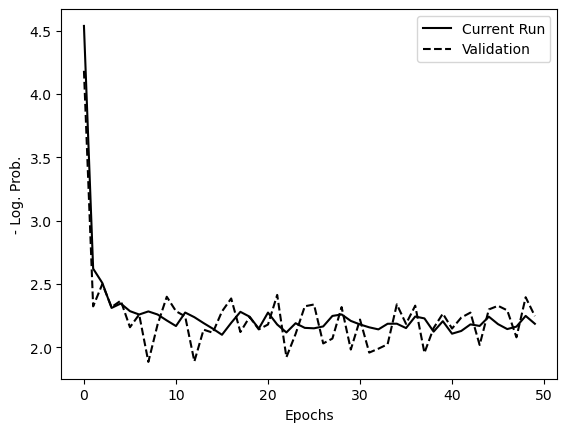

In [142]:
# plot the comparision of the train/val loss for the three scenarios

epoch_list = range(0,200)

plt.plot(epoch_list[:len(train_loss_list)], train_loss_list[:len(train_loss_list)], label = 'Current Run', color = 'k')
plt.plot(epoch_list[:len(val_loss_list)], val_loss_list[:len(val_loss_list)], label = 'Validation', color = 'k', linestyle = 'dashed')
plt.ylabel('- Log. Prob.')
plt.xlabel('Epochs')
plt.legend()

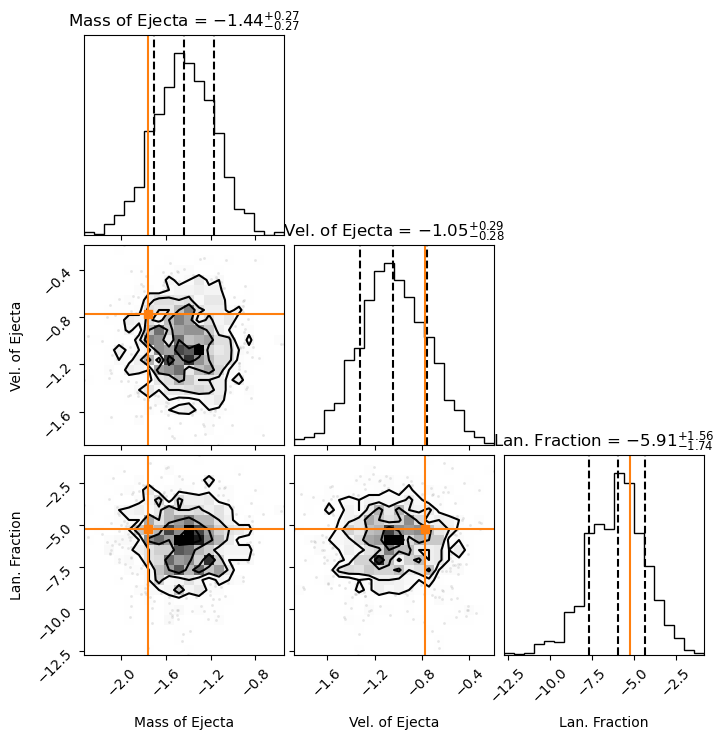

In [143]:
for idx, (shift_test, data_test) in enumerate(test_data_loader_flow):
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if idx % 100 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(1000, context=data_test[0].reshape((1, 3, num_points)))
    live_plot_samples(samples.cpu().reshape(1000,3), shift_test[0][0].cpu()[...,0:3])
    plt.show()